# BMM via Gaussian Processes: Matern kernel version

## Author: Alexandra Semposki

### Date last edited: 17 September 2024

In this notebook, we produce the results in Section IV B of our paper on applying BMM to the equation of state (EOS) of asymmetric nuclear matter. Here, we attempt to use `scikit-learn` to develop a GP with correlated data input to perform BMM, using an altered version of the `GaussianProcessRegressor` class from `sklearn` that is able to incorporate this correlated data. We start with an RBF kernel and a Constant Kernel to optimize the marginal variance, $\bar{c}^{2}$. This kernel choice can be changed to reflect other priors the user may wish to implement. 

---

#### Table of contents

1. [Setting up the training data](#setup)
2. [Calculation of the mixed model in $P(n)$](#calc_p_n)
3. [Calculation of the speed of sound squared, $c_{s}^{2}(n)$](#calc_cs2)

---

In [1]:
# import needed packages
%load_ext autoreload
%autoreload 2

import sys
import arviz as az
sys.path.append('../src/')
import scipy as sp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.axes import Axes
from sklearn.gaussian_process.kernels import RBF, Matern, ConstantKernel as C, WhiteKernel
from sklearn.gaussian_process.kernels import RationalQuadratic
from sklearn.gaussian_process import GaussianProcessRegressor

from gp_utils import GaussianProcessRegressor2dNoise
from eos_utils import *
from tov_utils import *
from scripts import *
from pqcd_reworked import PQCD

import sys
sys.path.append('../../../TOV_Solver')
from TOV_class import TOVsolver

# set params for plotting
setup_rc_params()

# define saturation up here
n0 = 0.164

# color plotting assistance
orders = [0, 1, 2, 3, 4, 5]
order_labels = [r'$\chi$EFT (N$^{3}$LO)', r'pQCD (N$^{2}$LO)', 'Mixed Model']
color_list = ['Reds', 'Blues','Purples', 'Oranges', 'Greens', 'Greys']
cmaps = [plt.get_cmap(name) for name in color_list[:len(orders)]]
colors = [cmap(0.7 - 0.1 * (i == 0)) for i, cmap in enumerate(cmaps)]
light_colors = [lighten_color(color, 0.5) for color in colors]
dark_colors = [lighten_color(color, 1.5) for color in colors]

---

## Setting up the training data <a id="setup"></a>

First, we load in the data sets from $\chi$EFT and pQCD from which we will select training points, and choose the N3LO and N2LO results, respectively. Notice that we are using the results from pure $\chi$EFT, up to $2n_{0}$ only, since GPs do not need to have training points across the entire space to be used.

In [2]:
data_xeft = np.load('../data/NSM_data/chiral_nsm_scaled.npz')
print(data_xeft['density'].shape)
data_pqcd = np.load('../data/eos_data/pressure_pqcd_data_scaled_NSM.npz')

(600,)


Now we do some Python gymnastics to obtain the training points we'd like to use.

In [4]:
# call training function to obtain desired data (for both data sets) (change now to test)
data_xeft_2 = {
    'density': data_xeft['density'][::2],
    'mean': data_xeft['mean'][::2],
    'std_dev': data_xeft['std_dev'][::2],
    'cov': data_xeft['cov'][::2,::2]
}

cutoff = 20
chiral_tr_data, pqcd_tr_data, training_data_new = gp_data(data_xeft_2, data_pqcd, cutoff, \
                                                          all_orders=False, matter='ANM')

# assign testing array (no equal points in training)
density_test = np.linspace(0.05, 16.4, 900)[:-1]

(8,) (8,) (8,) (8, 8)
(8,) (8,) (8,) (8, 8)
(7,) (7,) (7,) (7, 7)
Cov shape: (15, 15)


The cell below shows the results that we obtained for Table II in the paper (Sec. IV B). 

In [5]:
from scipy.linalg import block_diag

# make training data out of the first set
chiral_tr_final = {
    'dens': chiral_tr_data['dens'][1::2],  # 1::2
    'mean': chiral_tr_data['mean'][1::2],
    'std': chiral_tr_data['std'][1::2],
    'cov': chiral_tr_data['cov'][1::2,1::2]
}

pqcd_tr_final = {
    'dens': pqcd_tr_data['dens'],
    'mean': pqcd_tr_data['mean'],
    'std': pqcd_tr_data['std'],
    'cov': pqcd_tr_data['cov']
}

training_data = {
    'dens': np.concatenate((chiral_tr_final['dens'][1:], pqcd_tr_final['dens'])),
    'mean': np.concatenate((chiral_tr_final['mean'][1:], pqcd_tr_final['mean'])),
    'std': np.concatenate((chiral_tr_final['std'][1:], pqcd_tr_final['std'])),
    'cov': block_diag(chiral_tr_final['cov'][1:,1:], pqcd_tr_final['cov'])
}

training_data_2 = {
    'dens': np.concatenate((chiral_tr_final['dens'], pqcd_tr_final['dens'])),
    'mean': np.concatenate((chiral_tr_final['mean'], pqcd_tr_final['mean'])),
    'std': np.concatenate((chiral_tr_final['std'], pqcd_tr_final['std'])),
    'cov': block_diag(chiral_tr_final['cov'], pqcd_tr_final['cov'])
}

training_data_mix12 = {
    'dens': np.concatenate((chiral_tr_final['dens'], pqcd_tr_data['dens'][:-1])),
    'mean': np.concatenate((chiral_tr_final['mean'], pqcd_tr_data['mean'][:-1])),
    'std': np.concatenate((chiral_tr_final['std'], pqcd_tr_data['std'][:-1])),
    'cov': block_diag(chiral_tr_final['cov'], pqcd_tr_data['cov'][:-1,:-1])
}

training_data_mix21 = {
    'dens': np.concatenate((chiral_tr_data['dens'][:-1], pqcd_tr_final['dens'])),
    'mean': np.concatenate((chiral_tr_data['mean'][:-1], pqcd_tr_final['mean'])),
    'std': np.concatenate((chiral_tr_data['std'][:-1], pqcd_tr_final['std'])),
    'cov': block_diag(chiral_tr_data['cov'][:-1,:-1], pqcd_tr_final['cov'])
}

# print training data for Table II results
print('Density: \n', training_data['dens'])
print('\nMean: \n', training_data['mean'])
print('\nStd dev: \n', training_data['std'])

print('\nDensity: \n', training_data_2['dens'])
print('\nMean: \n', training_data_2['mean'])
print('\nStd dev: \n', training_data_2['std'])

Density: 
 [ 0.17103506  0.2484975   0.32595993  3.29816361  5.48180301  7.6654424
  9.8490818  12.0327212  14.2163606  16.4       ]

Mean: 
 [0.10521407 0.19189235 0.26642541 1.12216728 1.10108283 1.09103381
 1.08485423 1.0805493  1.07731912 1.07477293]

Std dev: 
 [0.01597702 0.03677041 0.07065512 0.03371912 0.02196701 0.01726267
 0.01465635 0.0129697  0.01177373 0.01087309]

Density: 
 [ 0.09357262  0.17103506  0.2484975   0.32595993  3.29816361  5.48180301
  7.6654424   9.8490818  12.0327212  14.2163606  16.4       ]

Mean: 
 [0.04384642 0.10521407 0.19189235 0.26642541 1.12216728 1.10108283
 1.09103381 1.08485423 1.0805493  1.07731912 1.07477293]

Std dev: 
 [0.00439573 0.01597702 0.03677041 0.07065512 0.03371912 0.02196701
 0.01726267 0.01465635 0.0129697  0.01177373 0.01087309]


Now we get ready to plot the selected training data and the total means and uncertainties from the two theories. $\chi$EFT and pQCD are always displayed in red and blue, respectively.

In [6]:
errorbar_kwargs = dict(
    capsize=3,
    ecolor="k",
    ls="none",
    marker="o",
    markerfacecolor="k",
    markeredgecolor="k",
    markersize=3
)

errorbar_kwargs_2 = dict(
    capsize=3,
    ecolor="r",
    ls="none",
    marker="o",
    markerfacecolor="r",
    markeredgecolor="r",
    markersize=3
)

In [7]:
# chiral EFT data 
n_xeft = data_xeft['density']
p_mean_xeft = data_xeft['mean']
p_stdv_xeft = data_xeft['std_dev']
p_cov_xeft = data_xeft['cov']

# get the pqcd curve to only plot greater than the cutoff choice
ind_cut = np.where(data_pqcd['density']/n0 >= cutoff)[0][0]

# pQCD data
n_pqcd = data_pqcd['density'][ind_cut:]
p_mean_pqcd = data_pqcd['mean'][ind_cut:, -1]
p_stdv_pqcd = data_pqcd['std_dev'][ind_cut:, -1]
p_cov_pqcd = data_pqcd['cov'][ind_cut:, ind_cut:, -1]

# save this for plotting later (uncomment to save)
#np.savez('../data/NSM_data/pressure_pqcd_cut_20_NSM.npz', dens=n_pqcd, mean=p_mean_pqcd, std=p_stdv_pqcd)

Now we'll plot the current data sets with the cutoffs implemented for each, and the training points that we will be using to train the GP.

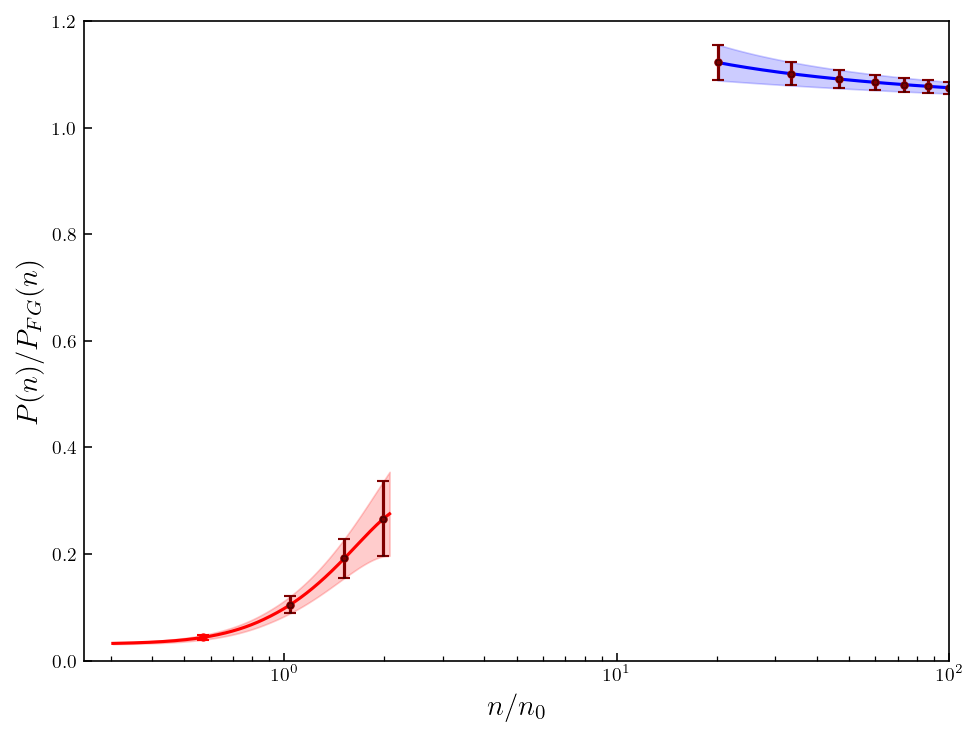

In [8]:
# plot the current data sets
fig, ax = plt.subplots(dpi=150)
ax: Axes
color_xeft = "red"
color_xeft_2 = 'green'
color_pqcd = "blue"
ax.set_xlim(0.25, 100.0)
ax.set_ylim(0, 1.2)
ax.set_xscale('log')
ax.set_ylabel(r'$P(n)/P_{FG}(n)$', fontsize=14)
ax.set_xlabel(r'$n/n_{0}$', fontsize=14)

# result of idea 1
ax.plot(n_xeft/n0, p_mean_xeft, color='red', label=r'ChEFT (N3LO)')
ax.fill_between(n_xeft/n0, p_mean_xeft-p_stdv_xeft, p_mean_xeft+p_stdv_xeft, \
                alpha=0.2, color=color_xeft)
ax.errorbar(x=training_data_2['dens']/n0, y=training_data_2['mean'], yerr=training_data_2['std'], \
            **errorbar_kwargs_2)
ax.errorbar(x=training_data['dens']/n0, y=training_data['mean'], yerr=training_data['std'], \
            **errorbar_kwargs, alpha=0.5)

ax.plot(n_pqcd/n0, p_mean_pqcd, color='blue', label=r'pQCD (N2LO)')
ax.fill_between(n_pqcd/n0, p_mean_pqcd-p_stdv_pqcd, p_mean_pqcd+p_stdv_pqcd, alpha=0.2, color=color_pqcd)
plt.show()

## Calculation of $P(n)$ using a GP <a id="calc_p_n"></a>

Now we construct the kernel we wish to use, the Matern * constant kernel. Then we will feed this to the `GaussianProcessRegressor2dNoise` function that ties to `sklearn`, and fit to the training data we selected.

We also need to compare the results of the work with the comparison of what happens when I use the same covariance matrix, and fix the lengthscale to reflect the two kernels I see when I work on the RBF kernel with two different covariance matrices.

In [9]:
# code matern kernel numerically and solve it
import math
val = 0.05  # this is 5% of the correlations persisting (tee hee yeah right)

def rbf_kernel(ls, euclidx):
    kernrbf = np.exp(-euclidx**2.0/(2.0*ls**2.0))
    return val - kernrbf 

def matern_32(ls, euclidx):
    kernmat32 = (1.0 + np.sqrt(3)*euclidx/ls) * np.exp(-np.sqrt(3)*euclidx/ls)
    return val - kernmat32

def matern_52(ls, euclidx):
    kernmat_52 = (1.0 + np.sqrt(5)*euclidx/ls + 5.0*euclidx**2.0/(3*ls**2.0)) \
           * np.exp(-np.sqrt(5)*euclidx/ls)
    return val - kernmat_52

def rat_quad(ls, alpha, euclidx):
    kernrq = (1.0 + euclidx**2.0/(2.0*alpha*ls**2.0))**(-alpha)
    return val - kernrq

def rbf_plot(ls, euclidx):
    kernrbf = np.exp(-euclidx**2.0/(2.0*ls**2.0))
    return kernrbf 

def matern_32_plot(ls, euclidx):
    kernmat32 = (1.0 + np.sqrt(3)*euclidx/ls) * np.exp(-np.sqrt(3)*euclidx/ls)
    return kernmat32

def matern_52_plot(ls, euclidx):
    kernmat_52 = (1.0 + np.sqrt(5)*euclidx/ls + 5.0*euclidx**2.0/(3*ls**2.0)) \
           * np.exp(-np.sqrt(5)*euclidx/ls)
    return kernmat_52

def rat_quad_plot(ls, alpha, euclidx):
    kernrq = (1.0 + euclidx**2.0/(2.0*alpha*ls**2.0))**(-alpha)
    return kernrq

from scipy.optimize import fsolve

if cutoff == 20:
    euclid_rbf = 2.31
    euclid_rat = 2.31
    euclid_matern = 2.31  # 1.187 for full + chiral
elif cutoff == 40:
    euclid_rbf = 3.0
    euclid_rat = 3.0    # only the gap
    euclid_matern = 3.0  # 1.88 for full + chiral
    
# rat quad choose alpha
alpha = 2.0

print(cutoff)

rootrbf = fsolve(rbf_kernel, [2.0], args=(euclid_rbf))
root52 = fsolve(matern_52, [2.0], args=(euclid_matern))
root32 = fsolve(matern_32, [2.0], args=(euclid_matern))
rootrat = fsolve(rat_quad, [2.0], args=(alpha, euclid_rat))

print('Length scale estimate, Matern 3/2: {}'.format((root32[0])))
print('Length scale estimate, Matern 5/2: {}'.format(root52[0]))
print('Length scale estimate, RBF: {}'.format(rootrbf[0]))
print('Length scale estimate, Rational Quadratic: {}'.format(rootrat[0]))

20
Length scale estimate, Matern 3/2: 0.8434130759791415
Length scale estimate, Matern 5/2: 0.872718879898618
Length scale estimate, RBF: 0.9437250499298965
Length scale estimate, Rational Quadratic: 0.6198457434321532


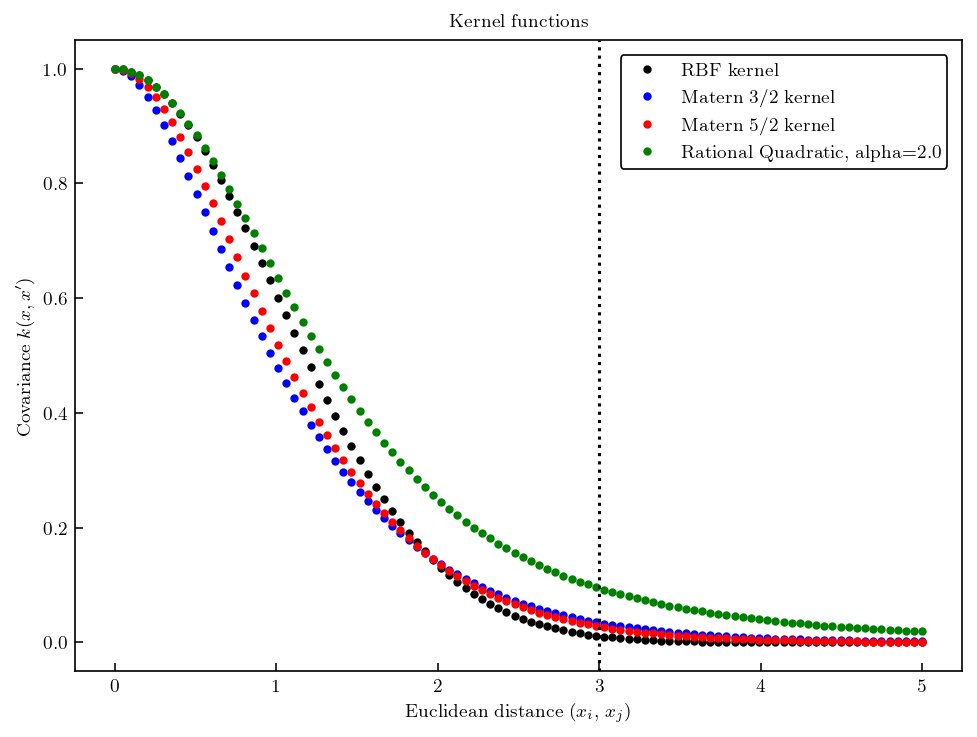

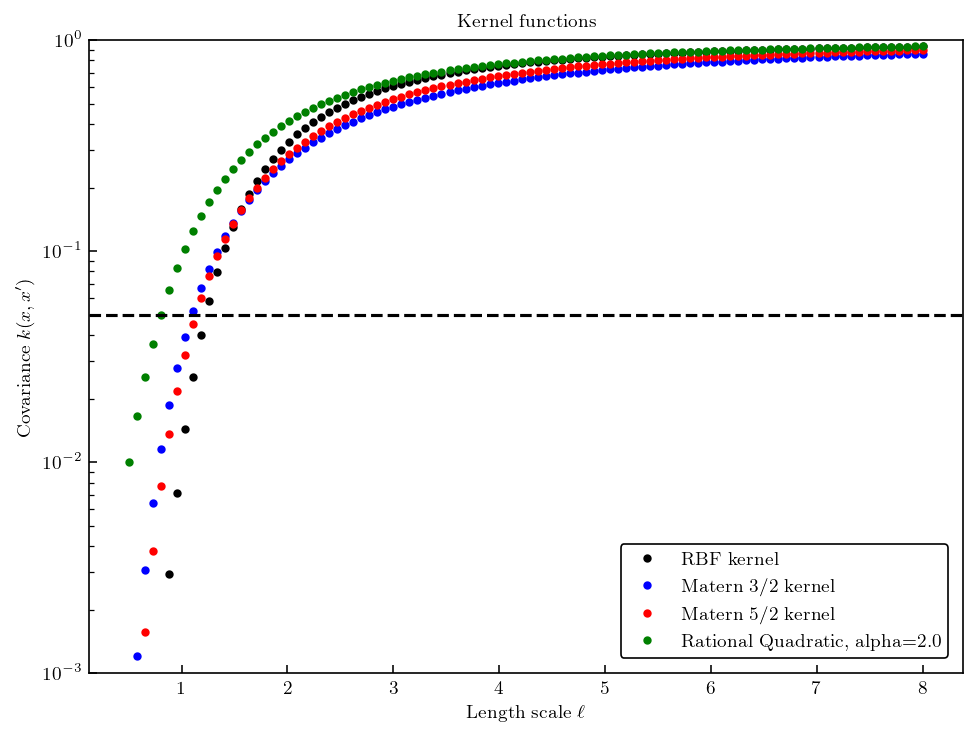

In [10]:
# plotting the functions with fixed length scales
ls = 1.0
alpha = 1.0
alpha2 = 0.5
alpha3 = 2.0
alpha4 = 5.0

# euclidean distance
euclidx = np.linspace(0.0, 5.0, 100)

# plot the functions
plt.plot(euclidx, rbf_plot(ls, euclidx), '.', color='black', label=r'RBF kernel')
plt.plot(euclidx, matern_32_plot(ls, euclidx), '.', color='blue', label=r'Matern 3/2 kernel')
plt.plot(euclidx, matern_52_plot(ls, euclidx), '.', color='red', label=r'Matern 5/2 kernel')
plt.plot(euclidx, rat_quad_plot(ls, 2.0, euclidx), '.', color='green', label=r'Rational Quadratic, alpha=2.0')
#plt.axvline(x=2.3, color='black', linestyle='dotted')
plt.axvline(x=3.0, color='black', linestyle='dotted')
plt.xlabel(r"Euclidean distance ($x_i$, $x_j$)")
plt.ylabel(r"Covariance $k(x,x')$")
plt.title('Kernel functions')
plt.legend()
plt.show()

# fixed Euclidean distance (what we really need to look at)
euclidx = 3.0
ls = np.linspace(0.5, 8.0, 100)

# plot the functions
plt.plot(ls, rbf_plot(ls, euclidx), '.', color='black', label=r'RBF kernel')
plt.plot(ls, matern_32_plot(ls, euclidx), '.', color='blue', label=r'Matern 3/2 kernel')
plt.plot(ls, matern_52_plot(ls, euclidx), '.', color='red', label=r'Matern 5/2 kernel')
plt.plot(ls, rat_quad_plot(ls, 2.0, euclidx), '.', color='green', label=r'Rational Quadratic, alpha=2.0')
plt.axhline(y=val, color='black', linestyle='dashed')
plt.xlabel(r"Length scale $\ell$")
plt.ylabel(r"Covariance $k(x,x')$")
plt.title('Kernel functions')
plt.yscale('log')
plt.ylim(1e-3, 1.0)
plt.legend(loc='lower right')
plt.show()

In [39]:
# choose kernel
if cutoff == 40:
        
    kernel_rbf = C(constant_value=1.1, constant_value_bounds=[0.3,2.25]) * \
    RBF(length_scale=1.1, length_scale_bounds=[1.0,1.18])
        
    kernel_mat52 = C(constant_value=1.1, constant_value_bounds=[0.3,2.25]) \
    * Matern(nu=2.5, length_scale=2.4, length_scale_bounds=[2.2,2.6])

    kernel_mat32 = C(constant_value=1.1, constant_value_bounds=[0.3, 2.25]) \
    * Matern(nu=1.5, length_scale=4.0, length_scale_bounds=[3.8,4.7])
    
    kernel_rat_fixed = C(constant_value=1.1, constant_value_bounds=[0.3,2.25]) * \
         RationalQuadratic(alpha=2.0, alpha_bounds='fixed', length_scale=1.15, length_scale_bounds=[1.1,1.2])
    
elif cutoff == 20:
    
  #  kernel_rbf = C(constant_value=1.1) * RBF(length_scale=1.0)
    
    kernel_rbf = C(constant_value=1.1, constant_value_bounds=[0.3,2.25]) * \
    RBF(length_scale=0.9, length_scale_bounds=[0.89, 0.95])
    
    kernel_mat52 = C(constant_value=1.1, constant_value_bounds=[0.3,2.25]) * \
    Matern(nu=2.5, length_scale=1.7, length_scale_bounds=[1.6, 2.0])
    
    kernel_mat32 = C(constant_value=1.1, constant_value_bounds=[0.3,2.25]) * \
    Matern(nu=1.5, length_scale=2.3, length_scale_bounds=[2.16, 3.3])
        
    kernel_rat_fixed = C(constant_value=1.1, constant_value_bounds=[0.3,2.25]) * \
         RationalQuadratic(alpha=2.0, alpha_bounds='fixed', length_scale=0.9, length_scale_bounds=[0.88, 0.95])

X_train = np.log(training_data['dens']).reshape(-1,1)  # training in the log scale
y_train = training_data['mean'].reshape(-1,1)

X_train_2 = np.log(training_data_2['dens']).reshape(-1,1)  # training in the log scale
y_train_2 = training_data_2['mean'].reshape(-1,1)

# create a small diagonal chicken nugget for the matrix (not needed without a prior?)
nugget_2 = 1e-08*np.diag(np.ones(len(training_data_2['cov'])))

# interpolate chiral and pQCD for some even spacing in log 
Xtestchi = []
Xtestpqcd = []
chiral_interp = interp1d(n_xeft, p_mean_xeft, kind='cubic', fill_value='extrapolate')
pqcd_interp = interp1d(n_pqcd, p_mean_pqcd, kind='cubic', fill_value='extrapolate')

# construct some log spacing to use
Xtotaltest = np.logspace(-3.0, 2.77, 50, base=np.e)
for i in range(len(Xtotaltest)):
    if Xtotaltest[i] <= n_xeft[-1]:
        Xtestchi.append(Xtotaltest[i])
    elif Xtotaltest[i] >= n_pqcd[0]:
        Xtestpqcd.append(Xtotaltest[i])
        
# use interpolant to generate some values
Ytestchi = chiral_interp(Xtestchi)
Ytestpqcd = pqcd_interp(Xtestpqcd)

# concatenate our arrays
Xtest = np.log(np.concatenate((Xtestchi, Xtestpqcd))).reshape(-1,1)
Ytest = np.concatenate((Ytestchi, Ytestpqcd)).reshape(-1,1)

print(cutoff)

20


In [40]:
# running plot of multiple hyperprior choices
gp = GaussianProcessRegressor2dNoise(
    kernel=kernel_rbf,
    alpha=training_data_2['cov'] + nugget_2,  # here is where we input the full covariance matrix from the data
    n_restarts_optimizer=10000,
)

gp.fit(X_train_2, y_train_2, priors=True, cutoff=cutoff, prior_choice='truncnorm') 

# running plot of multiple hyperprior choices
gp1 = GaussianProcessRegressor2dNoise(
    kernel=kernel_mat32,
    alpha=training_data_2['cov'] + nugget_2,  # here is where we input the full covariance matrix from the data
    n_restarts_optimizer=1000,
)

gp1.fit(X_train_2, y_train_2, priors=True, cutoff=cutoff, prior_choice='matern32') 

gp3 = GaussianProcessRegressor2dNoise(
    kernel=kernel_mat52,
    alpha=training_data_2['cov'] + nugget_2,  # here is where we input the full covariance matrix from the data
    n_restarts_optimizer=1000,
)

gp3.fit(X_train_2, y_train_2, priors=True, cutoff=cutoff, prior_choice='matern52') 

gp4 = GaussianProcessRegressor2dNoise(
    kernel=kernel_rat_fixed,
    alpha=training_data_2['cov'] + nugget_2,  # here is where we input the full covariance matrix from the data
    n_restarts_optimizer=1000,
)

gp4.fit(X_train_2, y_train_2, priors=True, cutoff=cutoff, prior_choice='ratquad') 


kernels = [r'RBF', r'Matern 3/2', r'Matern 5/2', r'Rational Quadratic, $\alpha=2$']

In [41]:
print(gp.kernel_)
print(gp1.kernel_)
print(gp3.kernel_)
print(gp4.kernel_)
print(cutoff)

0.817**2 * RBF(length_scale=0.95)
0.736**2 * Matern(length_scale=2.4, nu=1.5)
0.763**2 * Matern(length_scale=1.85, nu=2.5)
0.795**2 * RationalQuadratic(alpha=2, length_scale=0.949)
20


Value of maximum likelihood length scale: 1.0949494949494951
Value from the GP regression: 0.95
[[21.57962745 21.74921329 21.91816714 ... 35.21538796 35.32416581
  35.43225401]
 [21.40813805 21.57772389 21.74667774 ... 35.04389856 35.1526764
  35.26076461]
 [21.23732534 21.40691118 21.57586503 ... 34.87308585 34.98186369
  35.0899519 ]
 ...
 [ 7.95299584  8.12258168  8.29153553 ... 21.58875635 21.6975342
  21.8056224 ]
 [ 7.85168414  8.02126998  8.19022383 ... 21.48744464 21.59622249
  21.70431069]
 [ 7.7514271   7.92101294  8.08996679 ... 21.38718761 21.49596545
  21.60405366]]


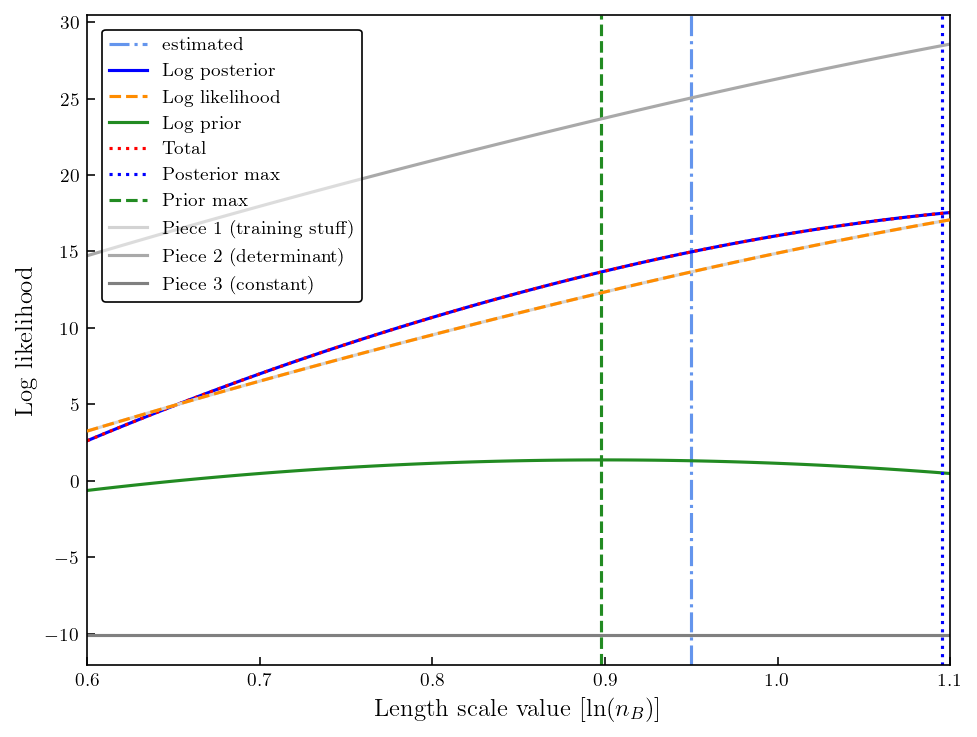

In [42]:
log_likelihood = []
test_ls = np.linspace(0.6,1.1,100)
logprior = []
loglikelihood = []
piece1 = []
piece2 = []
piece3 = []

for ls in test_ls:
    kernel = C(constant_value=1.1, constant_value_bounds=[1.1-0.0001, 1.1+0.0001]) * \
    RBF(length_scale=ls, length_scale_bounds=[ls-0.0001, ls+0.0001])
    gpcptest = GaussianProcessRegressor2dNoise(
    kernel=kernel,
    alpha=training_data_2['cov'] + nugget_2, # here is where we input the full covariance matrix from the data
    )
    gpcptest.fit(X_train_2, y_train_2, priors=True, prior_choice='truncnorm', \
                 cutoff=cutoff)
    log_likelihood.append(gpcptest.log_marginal_likelihood())
    loglikelihood.append(gpcptest.log_likelihood)
    logprior.append(gpcptest.log_prior)
    piece1.append(gpcptest.piece_1)
    piece2.append(gpcptest.piece_2)
    piece3.append(gpcptest.piece_3)
    
ind = np.where([np.asarray(log_likelihood[i]) >= max(log_likelihood) \
                for i in range(len(log_likelihood))])[0][-1]-1
ind_prior = np.where([np.asarray(logprior[i]) >= max(logprior) for i in range(len(logprior))])[0][-1]
ls_final = round(np.exp(gp.kernel_.theta[1]), 3)

# print some values to check
print('Value of maximum likelihood length scale: {}'.format(test_ls[ind]))
print('Value from the GP regression: {}'.format(ls_final))

#plt.xscale('log')
[plt.axvline(x=training_data_2['dens'][i], linestyle='dashed', color='lightgray') \
 for i in range(len(training_data_2['dens']))]
plt.axvline(x=ls_final, linestyle='-.', label='estimated', color='cornflowerblue')  

# plot the changepoint result
plt.plot(test_ls, log_likelihood, label=r'Log posterior', color='blue')
plt.plot(test_ls, loglikelihood, label=r'Log likelihood', linestyle='dashed', color='darkorange', zorder=20)
plt.plot(test_ls, logprior, label=r'Log prior', color='forestgreen')
plt.plot(test_ls, np.asarray(loglikelihood)+np.asarray(logprior), \
         label=r'Total', linestyle='dotted', color='red')
plt.axvline(x=test_ls[ind], linestyle='dotted', label=r'Posterior max', color='blue')
plt.axvline(x=test_ls[ind_prior], linestyle='dashed', label=r'Prior max', color='forestgreen')

# pieces of the log likelihood
plt.plot(test_ls, piece1, label=r'Piece 1 (training stuff)', color='lightgrey')
plt.plot(test_ls, piece2, label=r'Piece 2 (determinant)', color='darkgrey')
plt.plot(test_ls, piece3, label=r'Piece 3 (constant)', color='grey')

# rest of plot
plt.xlabel(r'Length scale value [$\ln(n_B)$]', fontsize=12)
plt.xlim(min(test_ls), max(test_ls))
plt.ylabel('Log likelihood', fontsize=12)
plt.legend()
#plt.plot(test_cp, np.gradient(loglikelihood, test_cp, edge_order=2))

print(np.asarray(piece2) - (np.asarray(piece1)+np.asarray(piece3)))

In [43]:
#conversion for speed of sound
convert_pqcd = np.load('../data/eos_data/pqcd_fg_data_NSM.npz')

# interpolate for a functional form to use 
convert_interp = sp.interpolate.interp1d(convert_pqcd['density'], convert_pqcd['mean'], \
                                 kind='cubic', fill_value='extrapolate')
pqcd_convert_arr = convert_interp(density_test)

In [44]:
# use the testing density array now for predicting at new locations (also in log space)
X = np.log(density_test).reshape(-1,1)

y_pred_0, y_stdv_0 = gp.predict(X, return_std=True)
_, y_cov_0 = gp.predict(X, return_cov=True)

y_pred_1, y_stdv_1 = gp1.predict(X, return_std=True)
_, y_cov_1 = gp1.predict(X, return_cov=True)

y_pred_3, y_stdv_3 = gp3.predict(X, return_std=True)
_, y_cov_3 = gp3.predict(X, return_cov=True)

y_pred_4, y_stdv_4 = gp4.predict(X, return_std=True)
_, y_cov_4 = gp4.predict(X, return_cov=True)

In [45]:
# save the data from each of these runs for the comparisons later
# np.savez('../data/Paper_data/stationary_kernels_20n0.npz', dens=density_test, \
#          rbfmean=y_pred_0, rbfstd=y_stdv_0, mat32mean=y_pred_1, mat32std=y_stdv_1, \
#         mat52mean=y_pred_3, mat52std=y_stdv_3, rqmean=y_pred_4, rqstd=y_stdv_4)

In [46]:
ind_chiral = np.where([density_test[i] <= 0.328 for i in range(len(density_test))])[0][-1]
print(density_test[ind_chiral])

if cutoff == 20:
    ind_pqcd = np.where([density_test[i] >= 3.28 for i in range(len(density_test))])[0][0]
elif cutoff == 40:
    ind_pqcd = np.where([density_test[i] >= 6.56 for i in range(len(density_test))])[0][0]

print(density_test[ind_pqcd])

0.3228031145717463
3.2872636262513897


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


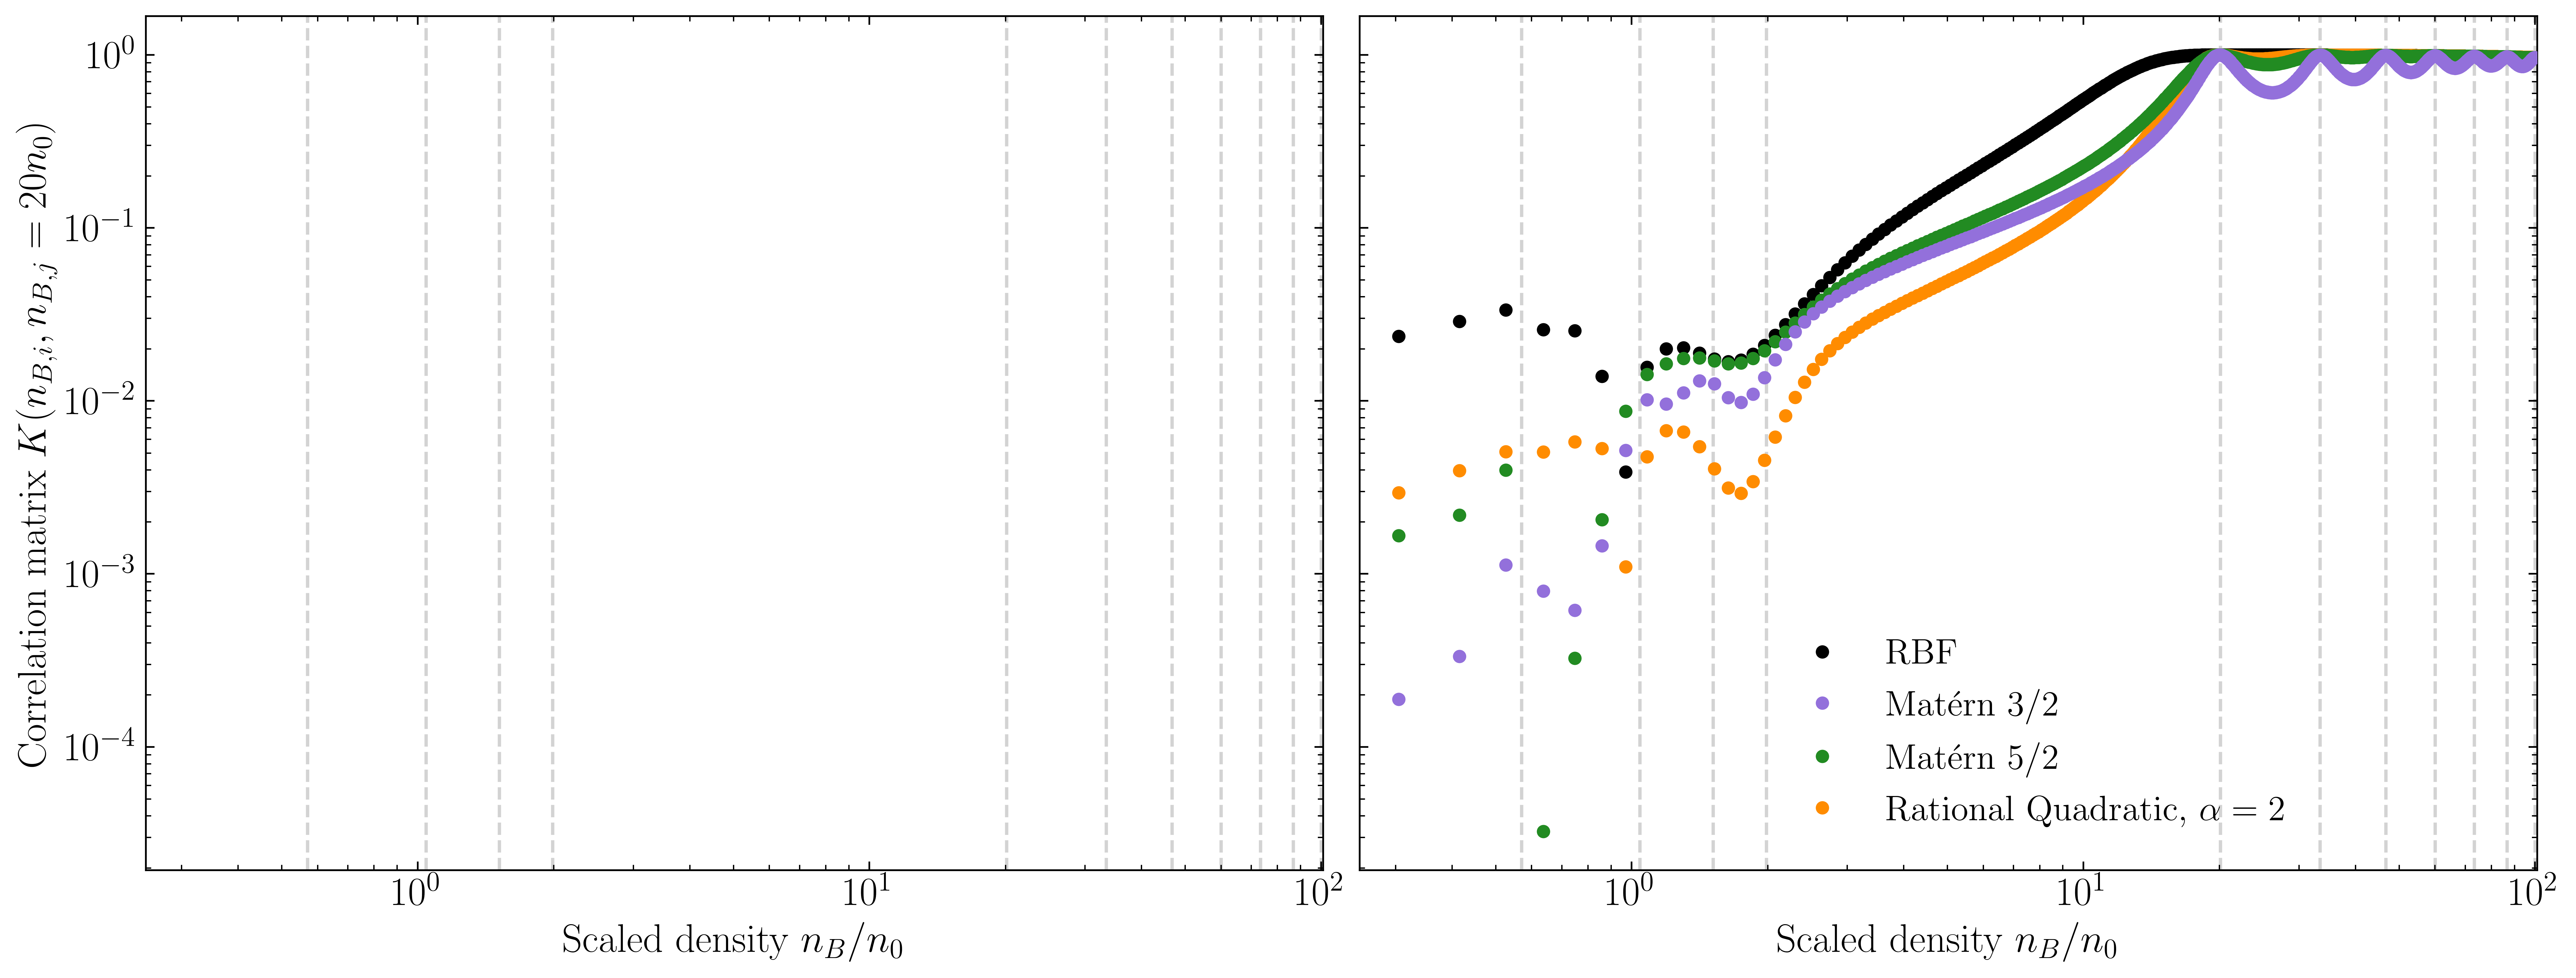

In [47]:
# cannot see from the covariance matrix very easily, let's plot the first row of each and see the differences
fig, ax = plt.subplots(1,2, figsize=(16,6), dpi=600, sharey=True)
[ax[0].axvline(x=training_data_2['dens'][i]/n0, color='lightgrey', linestyle='dashed', zorder=-10) \
 for i in range(len(training_data_2['dens']))]
[ax[1].axvline(x=training_data_2['dens'][i]/n0, color='lightgrey', linestyle='dashed', zorder=-10) \
 for i in range(len(training_data_2['dens']))]

# function to normalize the cov matrix
def normalize_covariance_matrix(cov_matrix):
    stds = np.sqrt(np.diag(cov_matrix))
    return cov_matrix / np.outer(stds, stds)

# blanket alpha to see through these points
alphaall = 1.0

# do this below for all 4 cases
ax[1].plot(density_test/n0, abs(normalize_covariance_matrix(y_cov_0)[:, ind_pqcd]), '.', \
         markersize=10, color='black', alpha=alphaall, label=r'RBF', zorder=0)
ax[1].plot(density_test/n0, abs(normalize_covariance_matrix(y_cov_1)[:, ind_pqcd]), '.', \
         markersize=10, color='mediumpurple', alpha=alphaall, label=r'Mat\'ern 3/2', zorder=10)
ax[1].plot(density_test/n0, abs(normalize_covariance_matrix(y_cov_3)[:, ind_pqcd]), '.', \
         markersize=10, color='forestgreen', alpha=alphaall, label=r'Mat\'ern 5/2', zorder=5)
ax[1].plot(density_test/n0, abs(normalize_covariance_matrix(y_cov_4)[:, ind_pqcd]), '.', \
         markersize=10, color='darkorange', alpha=alphaall, label=r'Rational Quadratic, $\alpha=2$', zorder=1)

ax[0].set_ylabel(r'Correlation matrix $K(n_{B,i}, n_{B,j}=20n_0)$', fontsize=18)

# loop over common attributes
for i in range(2):
    ax[i].set_yscale('log')
    ax[i].set_xlabel(r'Scaled density $n_B/n_0$', fontsize=18)
    ax[i].set_xscale('log')
    ax[i].set_xlim(0.25, 101.)
    ax[i].tick_params(right=True, top=True, which='both', labelsize=18)
    ax[i].legend(fontsize=16, frameon=False, bbox_to_anchor=[0.575, 0.32])
plt.show()

# save this data to make this plot in another notebook
np.savez('../data/Paper_data/cov_matrices_priors_20n0.npz', dens=density_test, \
         ichiral=ind_chiral, ipqcd=ind_pqcd, data_dens=training_data_2['dens'], \
         data_mean=training_data_2['mean'], \
          rbf=normalize_covariance_matrix(y_cov_0), mat32=normalize_covariance_matrix(y_cov_1), \
          mat52=normalize_covariance_matrix(y_cov_3), ratquad=normalize_covariance_matrix(y_cov_4))

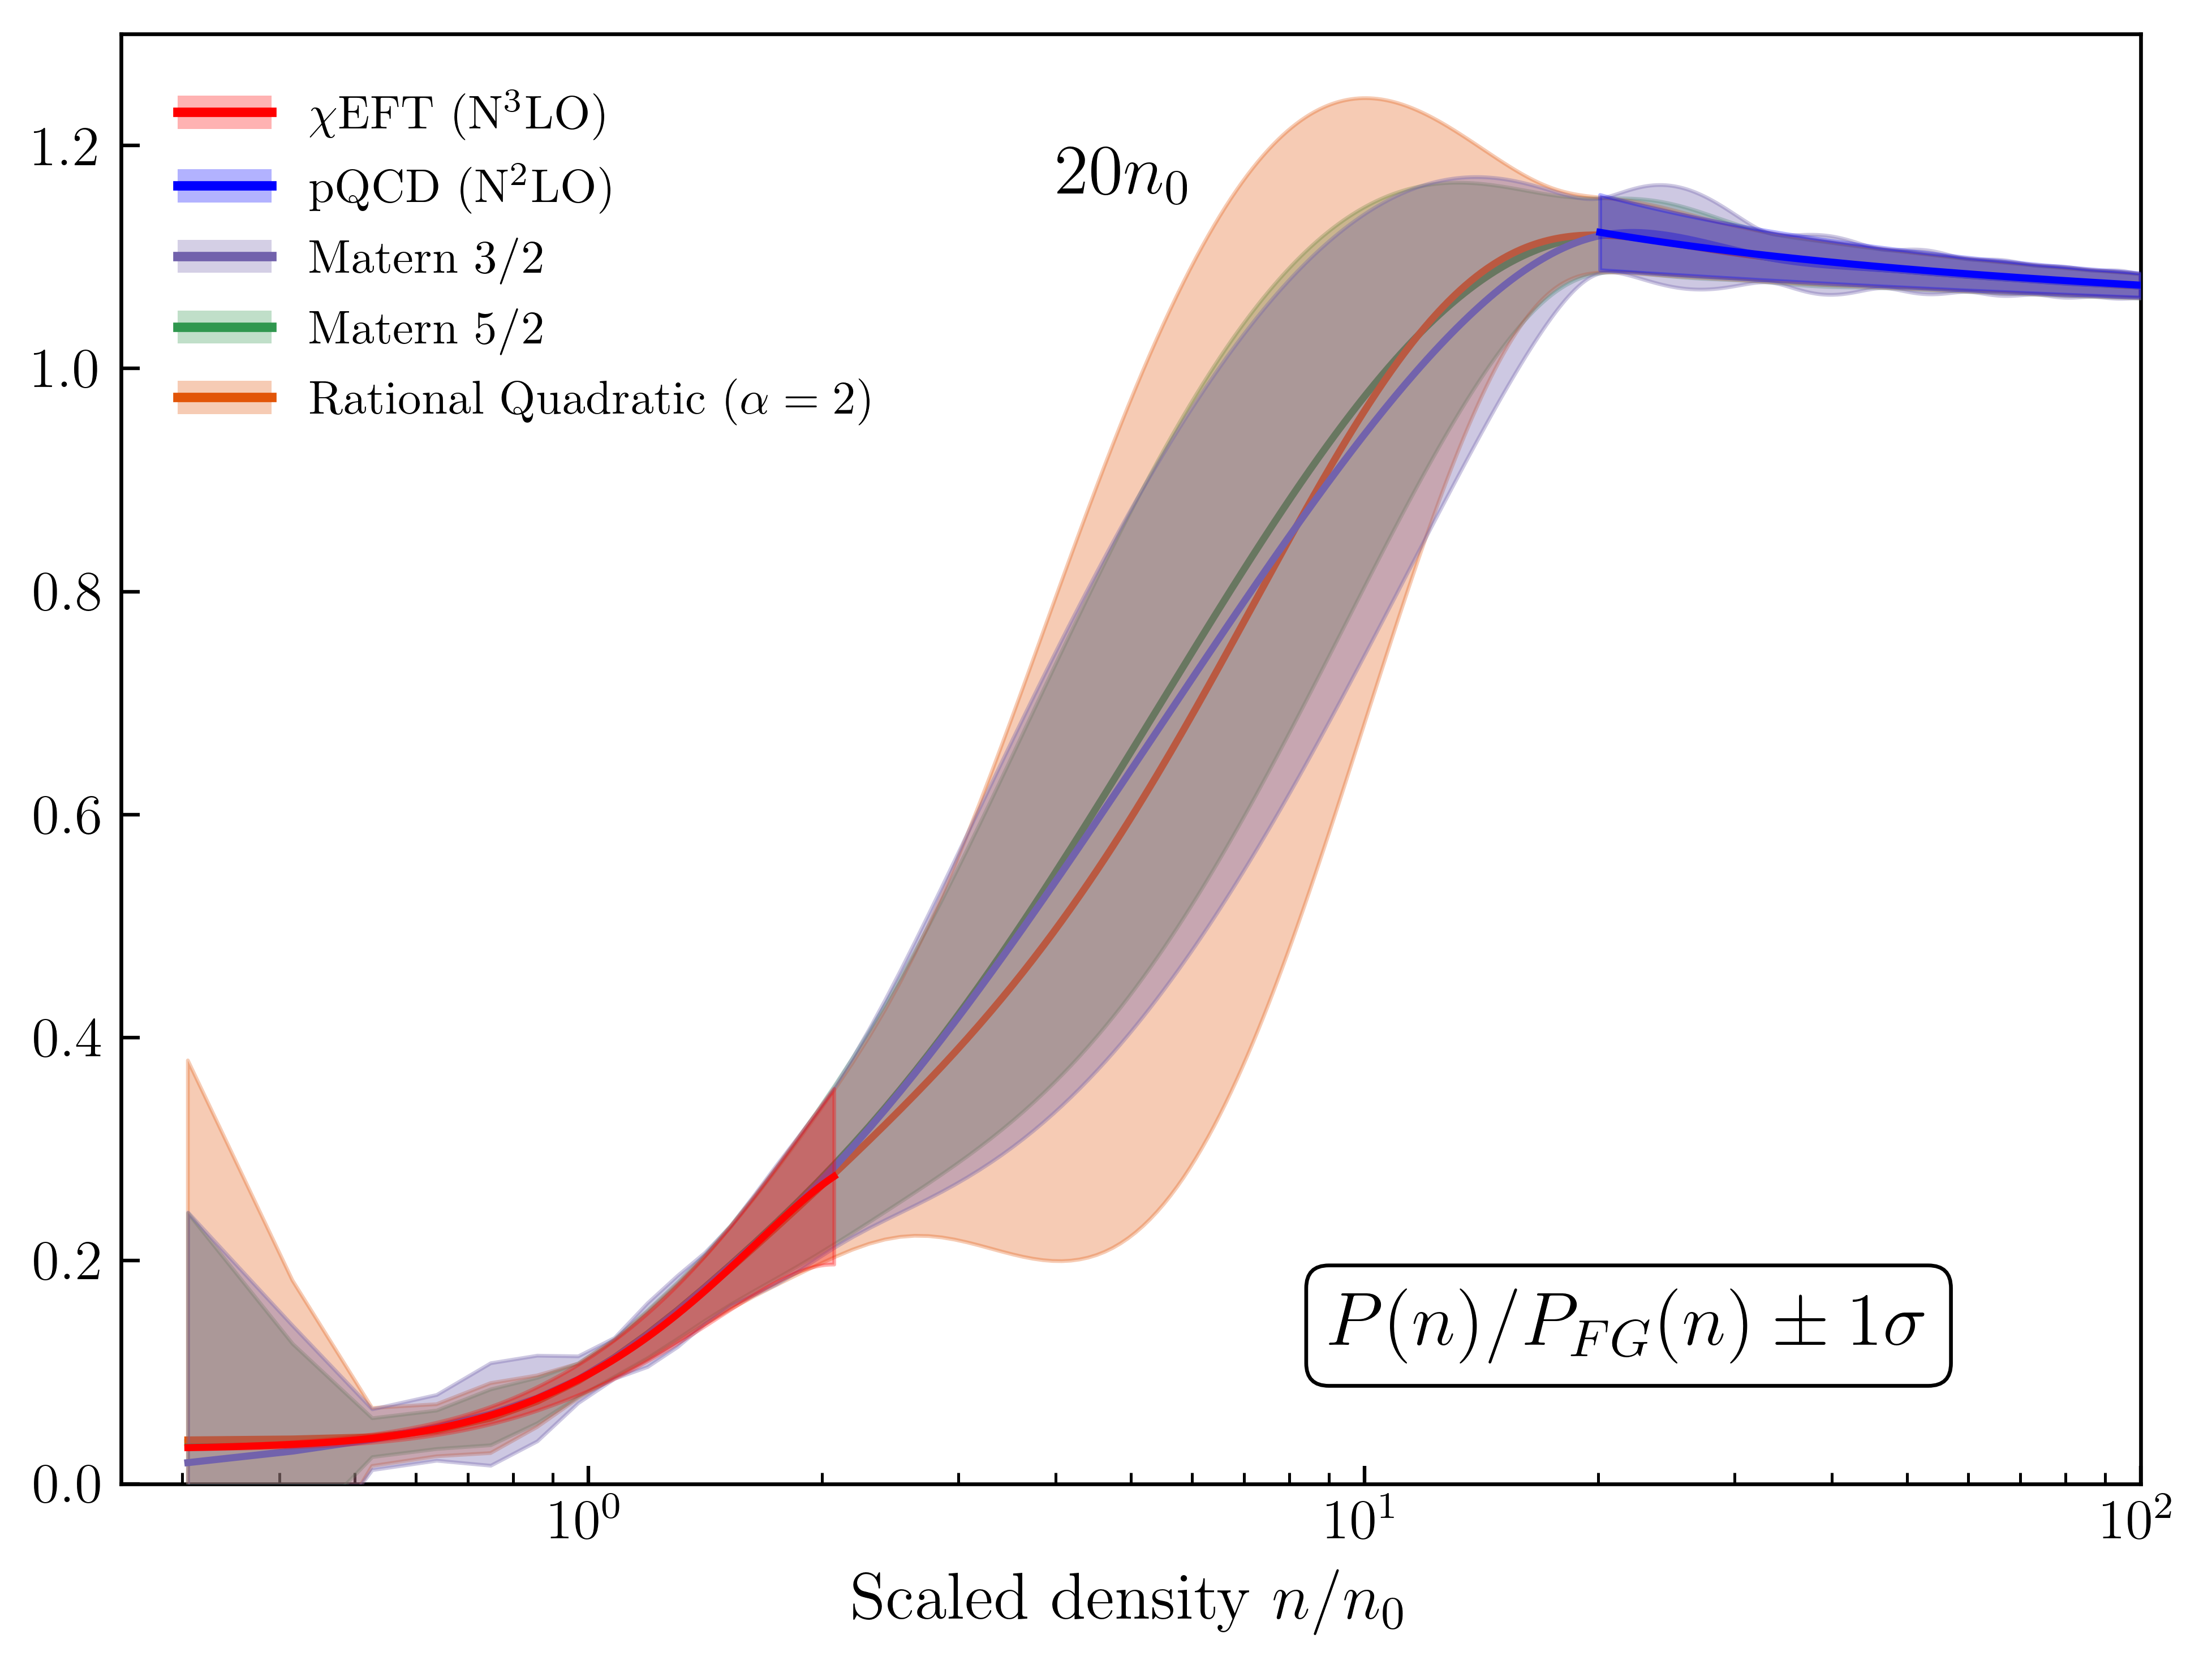

In [38]:
from scripts import add_uncertainty_legend
fig, ax = plt.subplots(dpi=600)
ax.set_xlim(min(density_test/n0), 100.0)
ax.set_ylim(0, 1.5)
ax.set_xscale('log')

# chiral EFT and pQCD curves, training data
ax.plot(n_xeft/n0, p_mean_xeft, color='red', label=r'ChEFT (N$^3$LO)', zorder=100)
ax.fill_between(n_xeft/n0, p_mean_xeft-p_stdv_xeft, p_mean_xeft+p_stdv_xeft, alpha=0.3, \
                color=color_xeft, zorder=99)
ax.plot(n_pqcd/n0, p_mean_pqcd, color='blue', label=r'pQCD (N$^2$LO)', zorder=100)
ax.fill_between(n_pqcd/n0, p_mean_pqcd-p_stdv_pqcd, p_mean_pqcd+p_stdv_pqcd, alpha=0.3, color=color_pqcd, \
               zorder=99)

# GP kernel choice results and uncertainty bands
ax.plot(density_test/n0, y_pred_1, color=colors[2], zorder=9)
ax.plot(density_test/n0, y_pred_3, color=colors[4], zorder=5)
ax.plot(density_test/n0, y_pred_4, color=colors[3], zorder=7)

ax.fill_between(density_test/n0, y_pred_1-y_stdv_1, y_pred_1+y_stdv_1, \
                label=r'{}'.format(kernels[1]), \
                color=colors[2], alpha=0.35, zorder=8)
ax.fill_between(density_test/n0, y_pred_3-y_stdv_3, y_pred_3+y_stdv_3, \
                label=r'{}'.format(kernels[2]), \
                color=colors[4], alpha=0.3, zorder=4)
ax.fill_between(density_test/n0, y_pred_4-y_stdv_4, y_pred_4+y_stdv_4, \
                label=r'{}'.format(kernels[3]), \
                color=colors[3], alpha=0.3, zorder=6)

plt.text(
    6.0,1.2, '${}n_0$'.format(cutoff), ha='right', va='top',
    multialignment='center', zorder=10, fontsize=15)

legend_entries = [
    (('red','red'), r'$\chi$EFT (N$^3$LO)'),
    (('blue', 'blue'), r'pQCD (N$^2$LO)'),
    ((colors[2], colors[2]), 'Matern 3/2'),
    ((colors[4], colors[4]), 'Matern 5/2'),
    ((colors[3], colors[3]), r'Rational Quadratic ($\alpha=2$)'),
]

plt.xlim(0.25, 100.0)
plt.ylim(0.0, 1.3)
#plt.axvline(x=0.08/n0, linestyle='dotted')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel(r'Scaled density $n/n_{0}$', fontsize=14)
add_uncertainty_legend(fig, ax, legend_entries, fontsize=10, loc='upper left', alpha=0.3)
ax.text(9.0, 0.125, r'$P(n)/P_{FG}(n) \pm 1\sigma$', fontsize=16, bbox=dict(facecolor='w', boxstyle='round'))
#plt.savefig('Plots/Matern/matern52_scaled_priors_15_20n0.png')
plt.show()

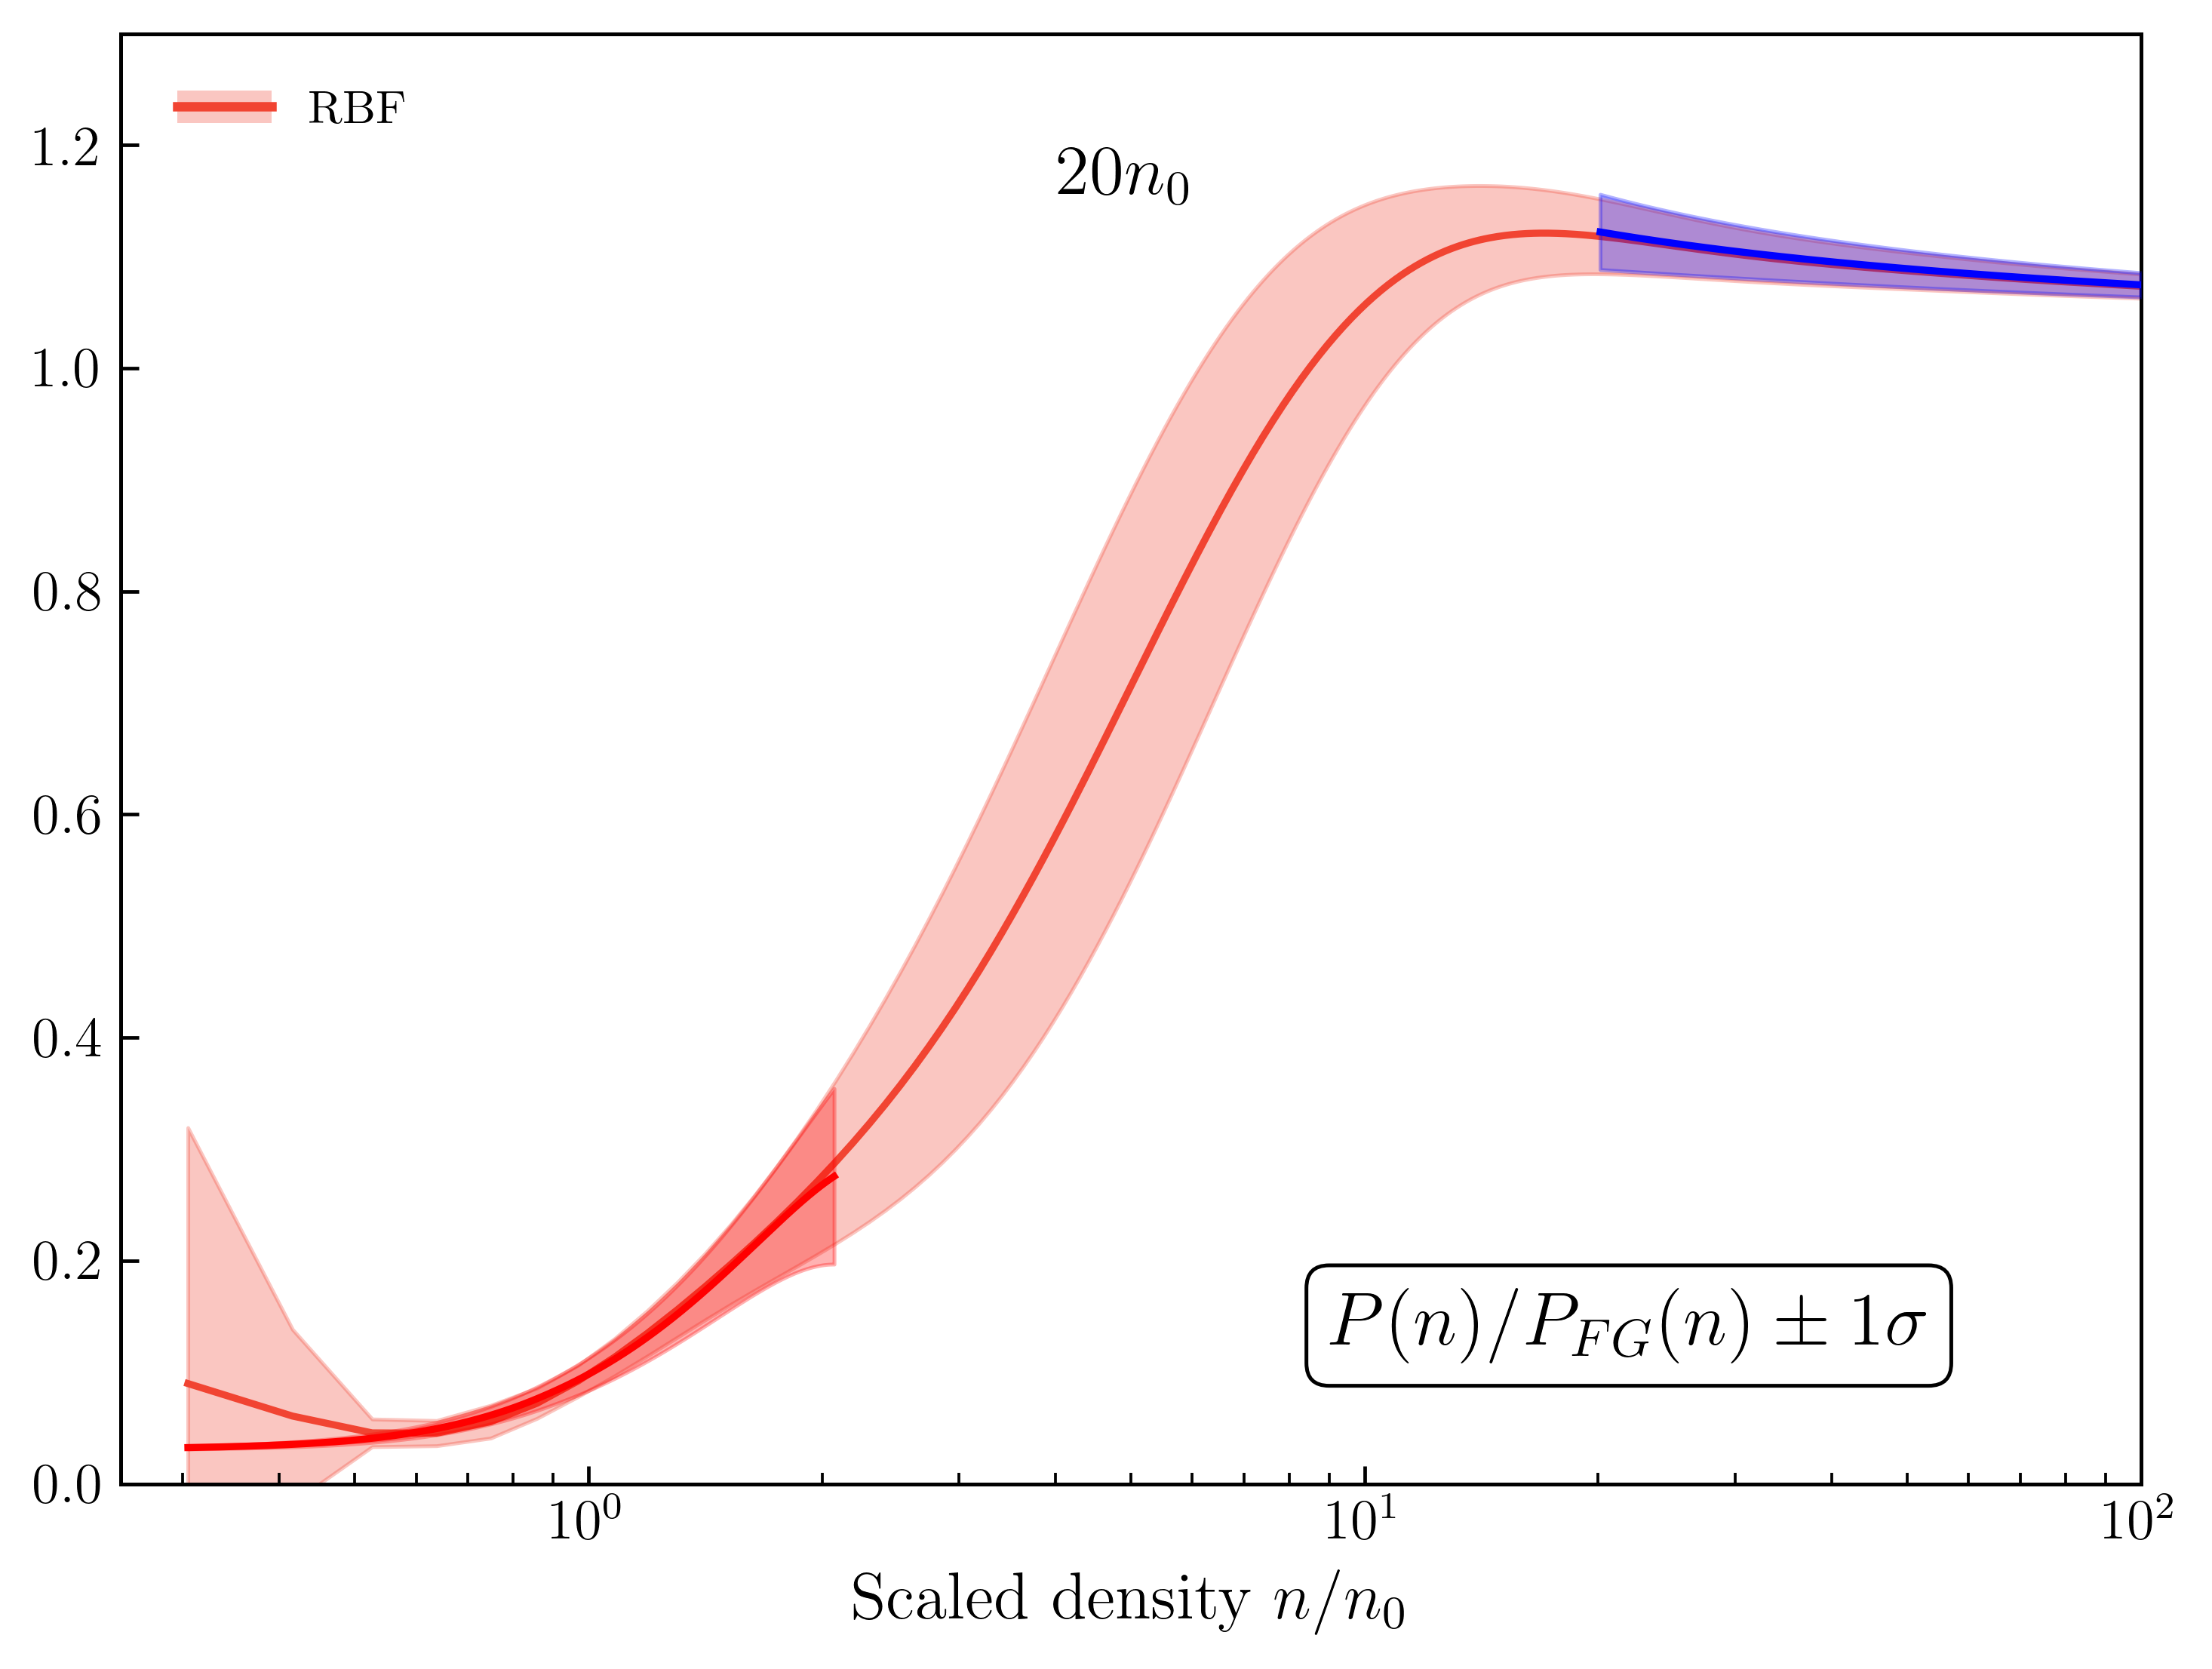

In [27]:
from scripts import add_uncertainty_legend
fig, ax = plt.subplots(dpi=450)
ax.set_xlim(min(density_test/n0), 100.0)
ax.set_ylim(0, 1.5)
ax.set_xscale('log') # plot in log base 10

# chiral EFT and pQCD curves, training data
ax.plot(n_xeft/n0, p_mean_xeft, color='red', label=r'ChEFT (N$^3$LO)', zorder=100)
ax.fill_between(n_xeft/n0, p_mean_xeft-p_stdv_xeft, p_mean_xeft+p_stdv_xeft, alpha=0.3, \
                color=color_xeft, zorder=99)
ax.plot(n_pqcd/n0, p_mean_pqcd, color='blue', label=r'pQCD (N$^2$LO)', zorder=100)
ax.fill_between(n_pqcd/n0, p_mean_pqcd-p_stdv_pqcd, p_mean_pqcd+p_stdv_pqcd, alpha=0.3, color=color_pqcd, \
               zorder=99)

# GP kernel choice results and uncertainty bands
ax.plot(density_test/n0, y_pred_0, color=colors[0])
ax.fill_between(density_test/n0, y_pred_0-y_stdv_0, y_pred_0+y_stdv_0, \
                label=r'{}'.format(kernels[0]), \
                color=colors[0], alpha=0.3)

plt.text(
    6.0,1.2, '${}n_0$'.format(cutoff), ha='right', va='top',
    multialignment='center', zorder=10, fontsize=15)

legend_entries = [
    ((colors[0], colors[0]), 'RBF')
]

plt.xlim(0.25, 100.0)
plt.ylim(0.0, 1.3)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel(r'Scaled density $n/n_{0}$', fontsize=14)
add_uncertainty_legend(fig, ax, legend_entries, fontsize=10, loc='upper left', alpha=0.3)
ax.text(9.0, 0.125, r'$P(n)/P_{FG}(n) \pm 1\sigma$', fontsize=16, bbox=dict(facecolor='w', boxstyle='round'))
plt.show()

In [160]:
# correlation coefficients with pQCD
index_2n0 = np.where([density_test[i] >= 0.34 for i in range(len(density_test))])[0][0]
index_40n0 = np.where([density_test[i] >= 6.56 for i in range(len(density_test))])[0][0]

print(density_test[index_2n0])
print(density_test[index_40n0])

# covariances RBF
y_stdv0_2n0 = y_stdv_0[index_2n0]
y_stdv0_40n0 = y_stdv_0[index_40n0]
y_cross0_2n0_40n0 = y_cov_0[index_2n0, index_40n0]

# covariances Matern 3/2
y_stdv1_2n0 = y_stdv_1[index_2n0]
y_stdv1_40n0 = y_stdv_1[index_40n0]
y_cross1_2n0_40n0 = y_cov_1[index_2n0, index_40n0]

# covariances Matern 5/2
y_stdv2_2n0 = y_stdv_3[index_2n0]
y_stdv2_40n0 = y_stdv_3[index_40n0]
y_cross2_2n0_40n0 = y_cov_3[index_2n0, index_40n0]

# covariances RQ
y_stdv3_2n0 = y_stdv_4[index_2n0]
y_stdv3_40n0 = y_stdv_4[index_40n0]
y_cross3_2n0_40n0 = y_cov_4[index_2n0, index_40n0]

# correlation coefficients
corr_coeff = y_cross0_2n0_40n0 / (y_stdv0_2n0 * y_stdv0_40n0)
corr_coeff_2 = y_cross1_2n0_40n0 / (y_stdv1_2n0 * y_stdv1_40n0)
corr_coeff_3 = y_cross2_2n0_40n0 / (y_stdv2_2n0 * y_stdv2_40n0)
corr_coeff_4 = y_cross3_2n0_40n0 / (y_stdv3_2n0 * y_stdv3_40n0)
print('Correlation coefficient, RBF: ', corr_coeff)  # look at how perfect this is!!!
print('Correlation coefficient, Matern 3/2: ', corr_coeff_2)
print('Correlation coefficient, Matern 5/2: ', corr_coeff_3)
print('Correlation coefficient, Rational Quadratic: ', corr_coeff_4)

0.3409899888765294
6.560901001112346
Correlation coefficient, RBF:  0.023578023200703766
Correlation coefficient, Matern 3/2:  0.01671392128805617
Correlation coefficient, Matern 5/2:  0.01865930106629664
Correlation coefficient, Rational Quadratic:  0.007124608989257372


### Other analysis

(899, 500)


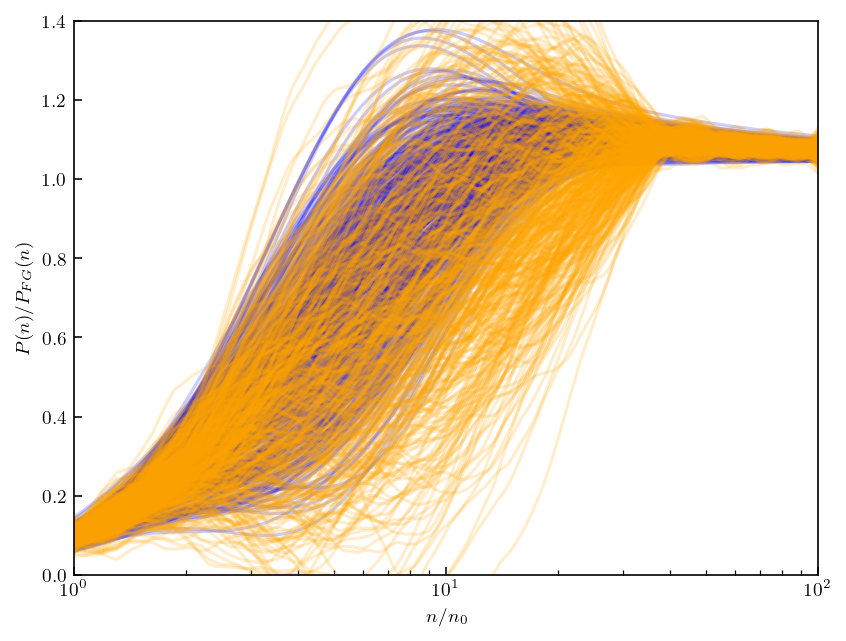

(899, 500)
Widths of (scaled) curves around saturation:
4 points: 0.39520174923118123
7 points: 1.9331143788140215
Chiral EFT: 0.36987807431182773
Widths of (scaled) curves around twice saturation:
4 points: 0.8289681401579152
7 points: 1.3069764367103816
Chiral EFT: 1.0774928240912232


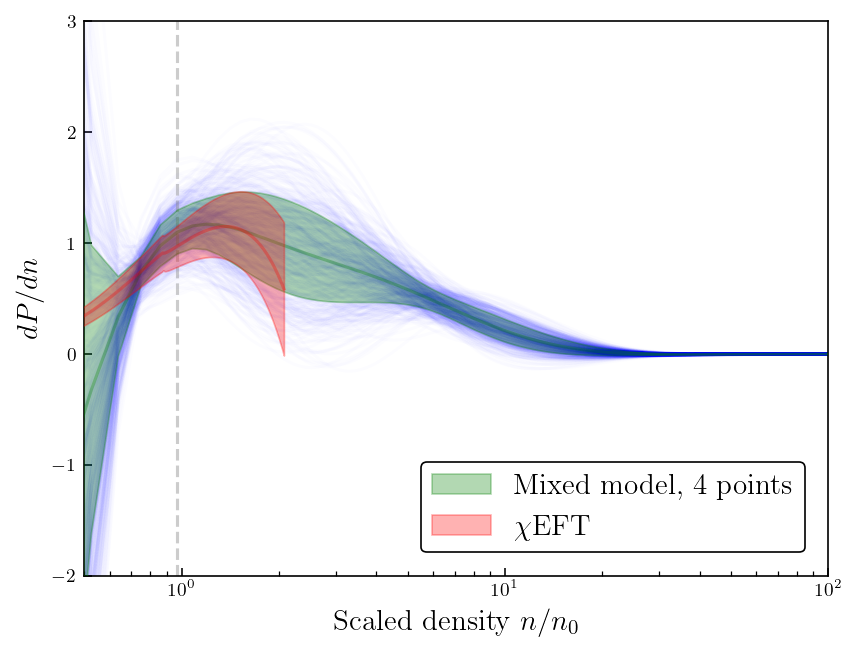

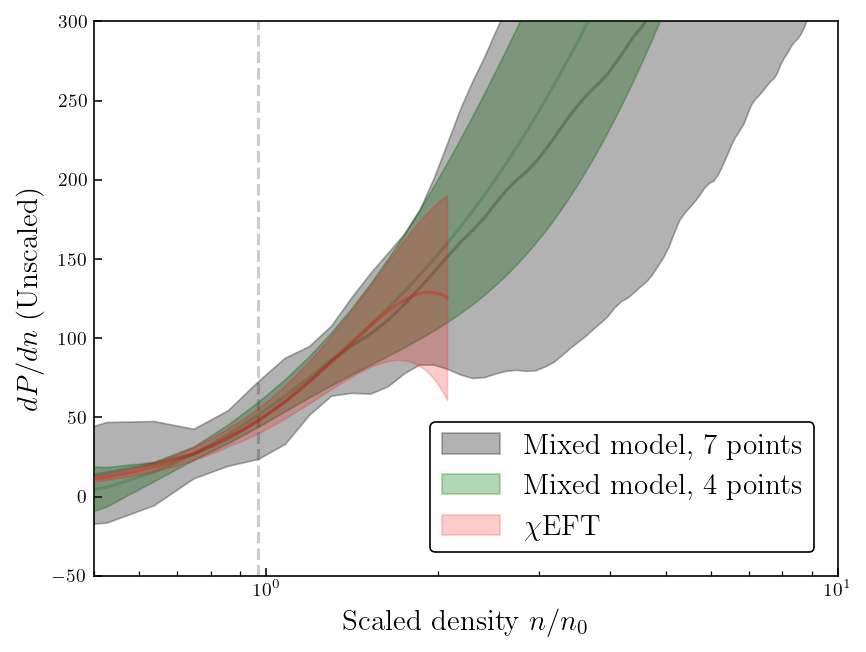

In [653]:
# investigate the derivative tendancies above for 4 vs. 7 points
deriv_chiral = np.load('../data/NSM_data/dP_dn_NSM_scaled.npz')
deriv_chiral_unscaled = np.load('../data/NSM_data/dP_dn_NSM.npz')

# obtain simple gradients for the two above first (lol these are hilariously uninformative as we guessed)
deriv_mixed4_mean = np.gradient(y_pred_0, density_test, edge_order=2)
deriv_mixed4_lower = np.gradient((y_pred_0 - y_stdv_0), density_test, edge_order=2)
deriv_mixed4_upper = np.gradient((y_pred_0 + y_stdv_0), density_test, edge_order=2)
deriv_mixed7_mean = np.gradient(y_pred_1, density_test, edge_order=2)
deriv_mixed7_lower = np.gradient((y_pred_1 - y_stdv_1), density_test, edge_order=2)
deriv_mixed7_upper = np.gradient((y_pred_1 + y_stdv_1), density_test, edge_order=2)

# plt.plot(density_test/n0, deriv_mixed4_mean, color='blue')
# plt.fill_between(density_test/n0, deriv_mixed4_lower, deriv_mixed4_upper, alpha=0.3, color='blue')
# plt.plot(density_test/n0, deriv_mixed7_mean, color='orange')
# plt.fill_between(density_test/n0, deriv_mixed7_lower, deriv_mixed7_upper, alpha=0.3, color='orange')
# plt.xscale('log')
# plt.show()

# moving on to drawing samples for a better look
samples = 500
samples_data4 = gp.sample_y(X=np.log(density_test.reshape(-1,1)), n_samples=samples)
samples_data7 = gp1.sample_y(X=np.log(density_test.reshape(-1,1)), n_samples=samples)

# undo the scaling from P_FG to see how this looks
print(samples_data4.shape)
samples4_unscaled = np.asarray([samples_data4[:,i]*pqcd_convert_arr \
                         for i in range(len(np.asarray(samples_data4).T))]).T
samples7_unscaled = np.asarray([samples_data7[:,i]*pqcd_convert_arr \
                         for i in range(len(np.asarray(samples_data7).T))]).T

# plot the samples to test the validity of the call
plt.plot(density_test/n0, samples_data4, color='blue', alpha=0.2)
plt.plot(density_test/n0, samples_data7, color='orange', alpha=0.2)
plt.xlim(1.0, 100.0)
plt.ylim(0.0, 1.4)
plt.xscale('log')
plt.ylabel(r'$P(n)/P_{FG}(n)$')
plt.xlabel(r'$n/n_{0}$')
plt.show()

# take derivatives of these samples (not the all-inclusive gptools variety though...
# but can be done anyway numerically, from what I can tell?)
# 4 
dPdn_samples4 = np.gradient(samples_data4, density_test, axis=0, edge_order=2)
dPdn_mean4 = np.nanmean(dPdn_samples4, axis=1)
dPdn_std4 = np.nanstd(dPdn_samples4, axis=1)

# 7
dPdn_samples7 = np.gradient(samples_data7, density_test, axis=0, edge_order=2)
dPdn_mean7 = np.nanmean(dPdn_samples7, axis=1)
dPdn_std7 = np.nanstd(dPdn_samples7, axis=1)

# 4 unscaled
print(samples4_unscaled.shape)
dPdn_samples4_unscaled = np.gradient(samples4_unscaled, density_test, axis=0, edge_order=2)
dPdn_mean4_unscaled = np.nanmean(dPdn_samples4_unscaled, axis=1)
dPdn_std4_unscaled = np.nanstd(dPdn_samples4_unscaled, axis=1)

# 7 unscaled
dPdn_samples7_unscaled = np.gradient(samples7_unscaled, density_test, axis=0, edge_order=2)
dPdn_mean7_unscaled = np.nanmean(dPdn_samples7_unscaled, axis=1)
dPdn_std7_unscaled = np.nanstd(dPdn_samples7_unscaled, axis=1)

# find approx. saturation density in the array
ind_sat = np.where([density_test[i] <= 0.164 for i in range(len(density_test))])[0][-1]
ind_chi = np.where([deriv_chiral['density'][i] <= density_test[ind_sat] \
                    for i in range(len(deriv_chiral['density']))])[0][-1]

# find approx. saturation density in the array
ind_sat_2n0 = np.where([density_test[i] <= 0.328 for i in range(len(density_test))])[0][-1]
ind_chi_2n0 = np.where([deriv_chiral['density'][i] <= density_test[ind_sat_2n0] \
                    for i in range(len(deriv_chiral['density']))])[0][-1]

width4_2n0 = (dPdn_mean4[ind_sat_2n0]+dPdn_std4[ind_sat_2n0]) - \
(dPdn_mean4[ind_sat_2n0] - dPdn_std4[ind_sat_2n0])
width7_2n0 = (dPdn_mean7[ind_sat_2n0]+dPdn_std7[ind_sat_2n0]) - \
(dPdn_mean7[ind_sat_2n0] - dPdn_std7[ind_sat_2n0])
widthchi_2n0 = (deriv_chiral['mean'][ind_chi_2n0] + \
            deriv_chiral['std'][ind_chi_2n0]) - (deriv_chiral['mean'][ind_chi_2n0] \
                                             -  deriv_chiral['std'][ind_chi_2n0])

# find the numbers at this line!!! unscaled and scaled versions
unscaled_width4 = (dPdn_mean4_unscaled+dPdn_std4_unscaled) - (dPdn_mean4_unscaled - dPdn_std4_unscaled)
unscaled_width7 = (dPdn_mean7_unscaled+dPdn_std7_unscaled) - (dPdn_mean7_unscaled - dPdn_std7_unscaled)
unscaled_widthchi = (deriv_chiral_unscaled['mean'][ind_chi] +  \
                     deriv_chiral_unscaled['std'][ind_chi]) - (deriv_chiral_unscaled['mean'][ind_chi] -  \
                                                      deriv_chiral_unscaled['std'][ind_chi])

width4 = (dPdn_mean4[ind_sat]+dPdn_std4[ind_sat]) - (dPdn_mean4[ind_sat] - dPdn_std4[ind_sat])
width7 = (dPdn_mean7[ind_sat]+dPdn_std7[ind_sat]) - (dPdn_mean7[ind_sat] - dPdn_std7[ind_sat])
widthchi = (deriv_chiral['mean'][ind_chi] + \
            deriv_chiral['std'][ind_chi]) - (deriv_chiral['mean'][ind_chi] \
                                             -  deriv_chiral['std'][ind_chi])

print('Widths of (scaled) curves around saturation:')
print('4 points: {}'.format(width4))
print('7 points: {}'.format(width7))
print('Chiral EFT: {}'.format(widthchi))

print('Widths of (scaled) curves around twice saturation:')
print('4 points: {}'.format(width4_2n0))
print('7 points: {}'.format(width7_2n0))
print('Chiral EFT: {}'.format(widthchi_2n0))
                                             
plt.plot(density_test/n0, dPdn_samples4, color='blue', alpha=0.01)
# plt.plot(density_test/n0, dPdn_samples7, color='orange', alpha=0.01)
# plt.fill_between(density_test/n0, dPdn_mean7-dPdn_std7, dPdn_mean7+dPdn_std7, color='black', \
#                  alpha=0.3, zorder=8, label=r'Mixed model, 7 points')
# plt.plot(density_test/n0, dPdn_mean7, color='black', alpha=0.3, zorder=9)
plt.fill_between(density_test/n0, dPdn_mean4-dPdn_std4, dPdn_mean4+dPdn_std4, color='green', \
                  alpha=0.3, zorder=6, label=r'Mixed model, 4 points')
plt.plot(density_test/n0, dPdn_mean4, color='green', alpha=0.3, zorder=7)
plt.fill_between(deriv_chiral['density']/n0, deriv_chiral['mean']-deriv_chiral['std'], \
                 deriv_chiral['mean']+deriv_chiral['std'], color='red', alpha=0.3, zorder=10, \
                 label=r'$\chi$EFT')
plt.plot(deriv_chiral['density']/n0, deriv_chiral['mean'], color='red', alpha=0.3, zorder=11)
plt.axvline(x=density_test[ind_sat]/n0, linestyle='dashed', color='grey', alpha=0.4)
plt.xlim(0.5, 100.0)
plt.xscale('log')
plt.ylabel(r'$dP/dn$', fontsize=14)
plt.ylim(-2.0, 3.0)
plt.xlabel(r'Scaled density $n/n_{0}$', fontsize=14)
plt.legend(fontsize=14, loc='lower right')
plt.show()

# unscaled plot
# plt.plot(density_test/n0, dPdn_samples4_unscaled, color='blue', alpha=0.01)
# plt.plot(density_test/n0, dPdn_samples7_unscaled, color='orange', alpha=0.01)
plt.fill_between(density_test/n0, dPdn_mean7_unscaled-dPdn_std7_unscaled, \
                 dPdn_mean7_unscaled+dPdn_std7_unscaled, color='black', \
                 alpha=0.3, zorder=8, label=r'Mixed model, 7 points')
plt.plot(density_test/n0, dPdn_mean7_unscaled, color='black', alpha=0.2, zorder=9)
plt.fill_between(density_test/n0, dPdn_mean4_unscaled-dPdn_std4_unscaled, \
                 dPdn_mean4_unscaled+dPdn_std4_unscaled, color='green', \
                 alpha=0.3, zorder=6, label=r'Mixed model, 4 points')
plt.plot(density_test/n0, dPdn_mean4_unscaled, color='green', alpha=0.2, zorder=7)
plt.fill_between(deriv_chiral_unscaled['density']/n0, \
                 deriv_chiral_unscaled['mean']-deriv_chiral_unscaled['std'], \
                 deriv_chiral_unscaled['mean']+deriv_chiral_unscaled['std'], \
                 color='red', alpha=0.2, zorder=10, label=r'$\chi$EFT')
plt.plot(deriv_chiral_unscaled['density']/n0, deriv_chiral_unscaled['mean'], \
         color='red', alpha=0.3, zorder=11)
plt.axvline(x=density_test[ind_sat]/n0, linestyle='dashed', alpha=0.4, color='grey')
plt.xlim(0.5, 10.0)
plt.xscale('log')
plt.ylabel(r'$dP/dn$ (Unscaled)', fontsize=14)
plt.ylim(-50.0, 300.0)
plt.xlabel(r'Scaled density $n/n_{0}$', fontsize=14)
plt.legend(fontsize=14, loc='lower right')
plt.show()

---

### Overlay of results for $20n_0$ and $40n_0$ $P(n)$

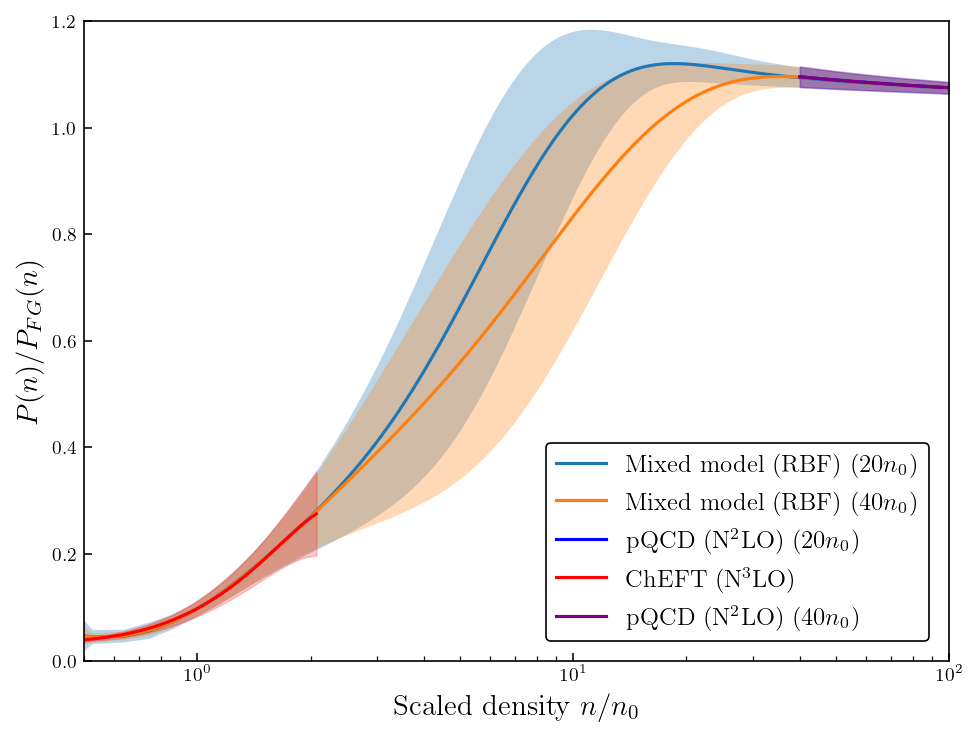

In [199]:
pqcd_20 = np.load('../data/NSM_data/pressure_pqcd_cut_20_NSM.npz')
pqcd_40 = np.load('../data/NSM_data/pressure_pqcd_cut_40_NSM.npz')
pressure_20 = np.load('../data/NSM_data/gp_pressure_20_NSM_NTG.npz')
pressure_40 = np.load('../data/NSM_data/gp_pressure_40_NSM_NTG.npz')
data_20 = np.load('../data/NSM_data/correlated_training_data_20n0_NSM.npz')
data_40 = np.load('../data/NSM_data/correlated_training_data_40n0_NSM.npz')

plt.plot(pressure_20['dens']/n0, pressure_20['mean'], label=r'Mixed model (RBF) ($20n_0$)')
plt.plot(pressure_40['dens']/n0, pressure_40['mean'], label=r'Mixed model (RBF) ($40n_0$)')
plt.fill_between(pressure_20['dens']/n0, pressure_20['mean']-pressure_20['std'], \
                 pressure_20['mean']+pressure_20['std'], alpha=0.3)
plt.fill_between(pressure_40['dens']/n0, pressure_40['mean']-pressure_40['std'], \
                 pressure_40['mean']+pressure_40['std'], alpha=0.3)

plt.plot(n_pqcd/n0, p_mean_pqcd, color='blue', label=r'pQCD (N$^2$LO) ($20n_0$)')
plt.fill_between(n_pqcd/n0, p_mean_pqcd-p_stdv_pqcd, p_mean_pqcd+p_stdv_pqcd, alpha=0.2, color=color_pqcd)
#plt.errorbar(x=data_40['density']/n0, y=data_40['mean'], yerr=data_40['std'], **errorbar_kwargs)

plt.plot(n_xeft/n0, p_mean_xeft, color='red', label=r'ChEFT (N$^3$LO)')
plt.fill_between(n_xeft/n0, p_mean_xeft-p_stdv_xeft, p_mean_xeft+p_stdv_xeft, alpha=0.2, \
                color=color_xeft)
# plt.errorbar(x=training_data_2['dens']/n0, y=training_data_2['mean'], yerr=training_data_2['std'], \
#             **errorbar_kwargs)

plt.plot(pqcd_40['dens']/n0, pqcd_40['mean'], color='purple', label=r'pQCD (N$^2$LO) ($40n_0$)')
plt.fill_between(pqcd_40['dens']/n0, pqcd_40['mean']-pqcd_40['std'], pqcd_40['mean']+pqcd_40['std'], \
                 alpha=0.2, color='purple')

plt.xlim(0.5, 100.0)
plt.ylim(0.0, 1.2)
plt.xlabel(r'Scaled density $n/n_{0}$', fontsize=14)
plt.ylabel(r'$P(n)/P_{FG}(n)$', fontsize=14)
plt.xscale('log')
plt.legend(loc='lower right', fontsize=12)
plt.savefig('overlay_pressures_NTG_RBF.png')
plt.show()

---

## Speed of sound calculation, $c_{s}^{2}(n)$ <a id="calc_cs2"></a>

We need to extract the speed of sound from the pressure equation. The most direct way to do this is to integrate the $P(n)$ curve to get the energy density, as we did as well in the pointwise mixing notebook. 

$$
P(n) = n^{2} \frac{\partial (\varepsilon/n)}{\partial n}
$$

$$
\varepsilon(n) = n \left[\int_{n}^{n_{i}} \frac{P(n)}{n^{2}} dn + \frac{\varepsilon(n_{i})}{n_{i}} \right],
$$

where $n_{i}$ is 16.4 fm$^{-3}$, as we will be integrating downwards from pQCD to $\chi$EFT in this approach.

After we achieve the energy density in this manner, we will then code the chemical potential as

$$
\mu(n) = \frac{P(n) + \varepsilon(n)}{n},
$$

and finally obtain the speed of sound, given as

$$
c_{s}^{2}(n) = \frac{\partial P}{\partial n } / \frac{\partial \varepsilon}{\partial n} = \frac{1}{\mu(n)} \frac{\partial P(n)}{\partial n}.
$$

We have a utility function that runs both the integration and the speed of sound calculation, so we will call that and implement the speed of sound. However, we first need to sample from the GP, since this is the way to best propagate the uncertainties from the pressure to the speed of sound without drastically overestimating them.

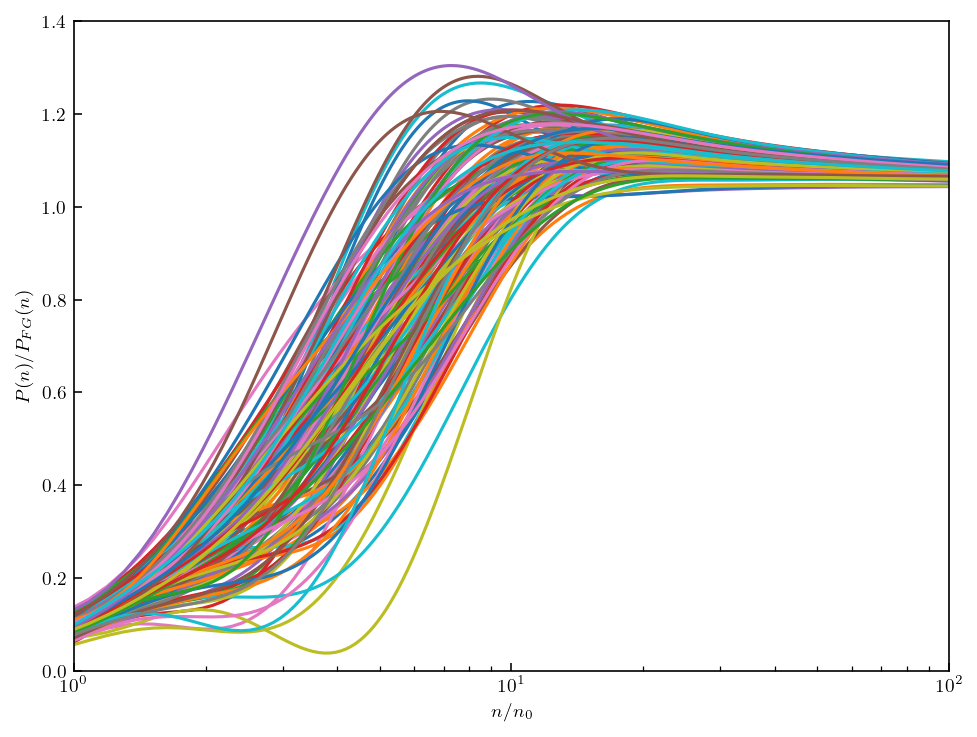

In [167]:
# sample from the pressure GP curve first (we'll need a LOT...eventually)
samples = 150
samples_data = gp.sample_y(X=np.log(density_test.reshape(-1,1)), n_samples=samples)

# plot the samples to test the validity of the call
plt.plot(density_test/n0, samples_data)
plt.xlim(1.0, 100.0)
plt.ylim(0.0, 1.4)
plt.xscale('log')
plt.ylabel(r'$P(n)/P_{FG}(n)$')
plt.xlabel(r'$n/n_{0}$')
plt.show()

In [169]:
# let's pull a couple of samples for some work with the kernels and hyperpriors
sample_store = {
    '20': [0,11,10],
    '40': [0,1,14]
}
samples_tests = 20
samples_data_tests = gp.sample_y(X=np.log(density_test.reshape(-1,1)), n_samples=samples_tests, \
                                 random_state=41)  # 2 good curves that look reasonable (got it)

# store in a single array
sample_true_20 = np.column_stack([samples_data_tests[:,j] for j in sample_store['20']])
sample_true_40 = np.column_stack([samples_data_tests[:,j] for j in sample_store['40']])
sample_true = np.column_stack([sample_true_20, sample_true_40])

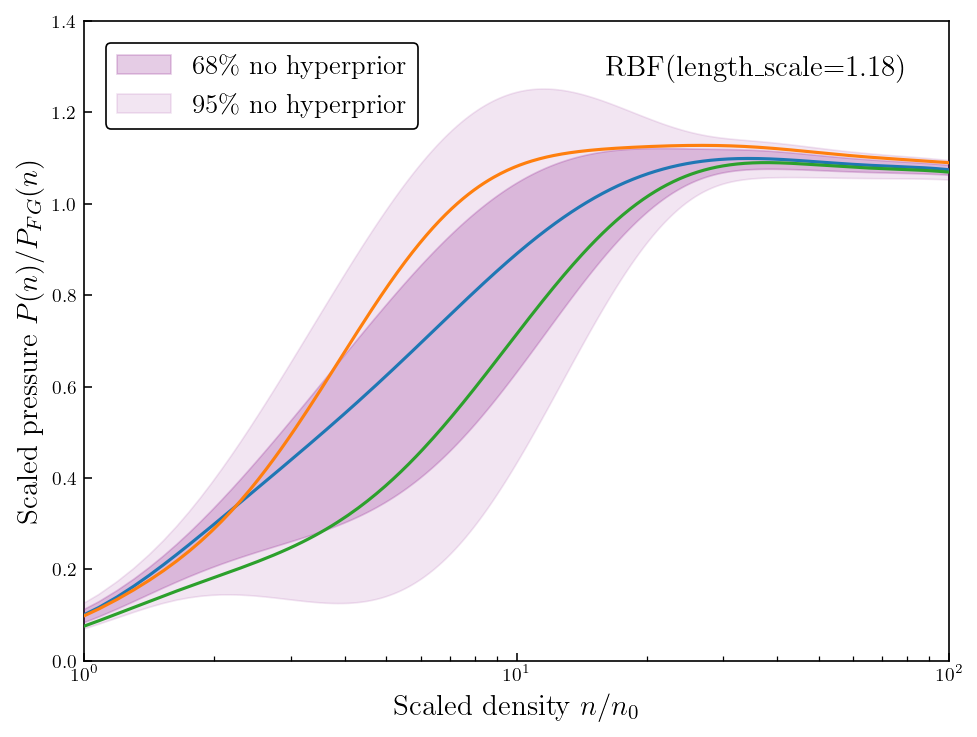

In [45]:
# plot with the 68% interval underneath for guidance
[plt.plot(density_test/n0, samples_data_tests[:,j], zorder=20) \
 for j in sample_store['40']]

gp_ls = gp1.kernel_.k2
plt.fill_between(density_test/n0, (y_pred_1-y_stdv_1), (y_pred_1+y_stdv_1), \
                 color='purple', alpha=0.2, zorder=10, label=r'68\% no hyperprior')
plt.fill_between(density_test/n0, (y_pred_1-1.96*y_stdv_1), (y_pred_1+1.96*y_stdv_1), \
                 color='purple', alpha=0.1, zorder=10, label=r'95\% no hyperprior')

plt.ylabel(r'Scaled pressure $P(n)/P_{FG}(n)$', fontsize=14)
plt.xlabel(r'Scaled density $n/n_{0}$', fontsize= 14)
plt.text(
    80.0,1.33, r'{}'.format(gp_ls), ha='right', va='top',
    multialignment='center', zorder=10, fontsize=14)
plt.xlim(1.0, 100.0)
plt.ylim(0.0, 1.4)
plt.xscale('log')
plt.legend(loc='upper left', fontsize=13)
#plt.savefig('Plots/analysis_priors/incremental_plots/fig6_20.png')
plt.show()

In [171]:
from eos_utils import cs2_routine, cs2_plots

# testing the function
gp_dict_full = {
    'dens': density_test,
    'mean': y_pred_0,
    'std_dev': y_stdv_0,
    'samples': samples_data,
    'true': None #sample_true
}

pres_dict, edens_full, cs2_sampled = cs2_routine(gp_dict=gp_dict_full, sat_cut=0, plot=False)

Sampling? True
Woo it is over!


In [23]:
# number of samples
samples = len(pres_dict['samples'].T)
print(samples)

# TOV data creation (streamlined)
tov_dict = tov_data(edens_full, pres_dict)

# run the TOV solver over each sample (very janky for now)
mass_data = np.zeros([50,samples])
radius_data = np.zeros([50,samples])
pressure_data = np.zeros([50,samples])

# call the solver once, send all data directly
tov = TOVsolver(eos_filepath='../../../FASTAR/TOV/Alexandra_TOV/eos_tov_true.npz')

# call routine once (should do its thing...check why central pressures are the same for different ones)
radius_data, pressure_data, mass_data = tov.tov_routine(verbose=False)

150
Data not saved.
Woo it worked!
37
Radius:  10.327493576 Maximum mass:  1.6081776680094848 Central pressure:  399.5007639993038
36
Radius:  11.8820616368 Maximum mass:  2.0198061584526896 Central pressure:  342.0973067434033
37
Radius:  8.5451008856 Maximum mass:  1.0475987843077235 Central pressure:  399.5007639993038
37
Radius:  10.327493576 Maximum mass:  1.6081776680094848 Central pressure:  399.5007639993038
36
Radius:  11.9758717784 Maximum mass:  2.087881948192134 Central pressure:  342.0973067434033
43
Radius:  7.1513502104 Maximum mass:  1.1199026137321497 Central pressure:  1013.2704295883759


In [25]:
# now work with the mean and std of pressure, energy density (envelope calculation)
# edens_lower = edens_mean - edens_std
# edens_higher = edens_mean + edens_std
# pres_lower = gp_mean - gp_std
# pres_higher = gp_mean + gp_std
# gp_res = np.column_stack([pres_lower, gp_mean, pres_higher])

# # concatenate into "samples"
# edens_envelope = np.column_stack([edens_lower, edens_mean, edens_higher])

# # save data in dat file backwards
# tov_index = (np.where([density_test[i] <= 0.08 for i in range(len(density_test))])[0][-1] + 1)
# edens_final = edens_envelope[tov_index:]
# gp_final = np.asarray([gp_res[tov_index:, i]*\
#                        convert_interp(density_test[tov_index:]) for i in range(3)]).T
# density_final = density_test[tov_index:]

# # run through and append the low density data to these arrays and then save to file
# edens_tov = np.asarray([np.concatenate((low_den_file[::-1,0], edens_final[:,i])) for i in range(3)]).T
# pres_tov = np.asarray([np.concatenate((low_den_file[::-1,1], gp_final[:,i])) for i in range(3)]).T
# dens_tov = np.concatenate((low_den_file[::-1,2], density_final)).reshape(-1,1)
# cs2_tov = np.zeros(len(density_final) + len(low_den_file[:,0]))

# end result of file needed
# np.savez("../../../FASTAR/TOV/Alexandra_TOV/eos_tov_env_test_40n0.npz", density=dens_tov, \
#          edens=edens_tov, pres=pres_tov, cs2=cs2_tov)

In [78]:
# run the TOV solver over each sample (very janky for now) -> what's up here rn...? weird crossings?
mass_data_env = np.zeros([50,3])
radius_data_env = np.zeros([50,3])
pressure_data_env = np.zeros([50,3])

# call solver once, call routine once
tov_env = TOVsolver(eos_filepath="../../../FASTAR/TOV/Alexandra_TOV/eos_tov_env_test_40n0.npz")
radius_data_env, pressure_data_env, mass_data_env = tov_env.tov_routine(verbose=False)

Woo it worked!
Radius:  9.121818947199998 Maximum mass:  1.2086863910819774 Central pressure:  466.5364423805275
Radius:  9.708161655199998 Maximum mass:  1.441772445579273 Central pressure:  399.5007639993038
Radius:  9.389861327999999 Maximum mass:  1.5643754279388329 Central pressure:  544.8206153354404


---

In [172]:
# import the speed of sound data from ChEFT and pQCD
cs2_chiral = np.load('../data/NSM_data/cs2_chiral_NSM.npz')
cs2_pqcd = np.load('../data/eos_data/pqcd_cs2_NSM.npz')  # --> are we using the correct result here?

---

## Saving EOS data for the TOV solver

In [70]:
# append the low density data to these arrays when reversed
low_den_file = np.loadtxt("../data/NSM_data/MFT_ns6p.dat", skiprows=1)

# save data in dat file backwards (without cs2 to start)
tov_index = (np.where([density_test[i] <= 0.08 for i in range(len(density_test))])[0][-1] + 1)
edens_final = edens_mean[tov_index:]
gp_final = gp_mean[tov_index:]*convert_interp(density_test[tov_index:])
density_final = density_test[tov_index:]

# run through and append the low density data to these arrays and then save to file
edens_tov = np.concatenate((low_den_file[::-1,0], edens_final))
pres_tov = np.concatenate((low_den_file[::-1,1], gp_final))
dens_tov = np.concatenate((low_den_file[::-1,2], density_final))
cs2_tov = np.zeros(len(density_final) + len(low_den_file[:,0]))

# end result of file needed
tov_data = np.column_stack([edens_tov, pres_tov, dens_tov, cs2_tov])
np.savetxt("../../../FASTAR/TOV/Alexandra_TOV/eos_tov_40n0.dat", tov_data)

# try saving to an npz file instead
np.savez('../../../FASTAR/TOV/Alexandra_TOV/eos_zip_test.npz', density=dens_tov, edens=edens_tov, pres=pres_tov, cs2 = cs2_tov)

In [71]:
# try running the solver class object for the npz file format and txt file format
import sys
sys.path.append('../../../TOV_Solver/')
from TOV_class import TOVsolver
tov = TOVsolver(eos_filepath='../../../FASTAR/TOV/Alexandra_TOV/eos_zip_test.npz')

# try running for the single sample and see what happens
max_radius, max_pres_central, max_mass = tov.tov_routine(verbose=False)

Woo it worked!
Radius:  9.453070236289815 Maximum mass:  1.4143352649354075


---

---

Alexandra Semposki, 01 April 2024.